In [122]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px

In [123]:
print("\n--- Performance Metrics Comparison ---")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Hybrid MAE: {mae_hybrid:.2f}")
print("-" * 20)
print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Hybrid RMSE: {rmse_hybrid:.2f}")
print("-" * 20)
print(f"Prophet MAPE: {mape_prophet:.2f}%")
print(f"Hybrid MAPE: {mape_hybrid:.2f}%")
print("-" * 20)
print(f"Prophet R²: {r2_prophet:.3f}")
print(f"Hybrid R²: {r2_hybrid:.3f}")

print("\n--- Interpretation ---")
print("MAE (Mean Absolute Error): Average magnitude of the errors in a set of forecasts, without considering their direction. Lower is better.")
print(f"Hybrid MAE ({mae_hybrid:.2f}) is lower than Prophet MAE ({mae_prophet:.2f}), indicating smaller average errors for the Hybrid model.")

print("\nRMSE (Root Mean Squared Error): Measures the square root of the average of the squared errors. It gives a relatively high weight to large errors. Lower is better.")
print(f"Hybrid RMSE ({rmse_hybrid:.2f}) is lower than Prophet RMSE ({rmse_prophet:.2f}), suggesting the Hybrid model has fewer large errors.")

print("\nMAPE (Mean Absolute Percentage Error): Measures the accuracy of forecasts as a percentage of the actual values. Useful for comparing models across different scales. Lower is better.")
print(f"Hybrid MAPE ({mape_hybrid:.2f}%) is significantly lower than Prophet MAPE ({mape_prophet:.2f}%), indicating the Hybrid model has a lower average percentage error relative to actual sales.")

print("\nR² (Coefficient of Determination): Represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A value closer to 1 is better, while negative values indicate that the model performs worse than simply predicting the mean.")
print(f"Both models have negative R² values (Prophet: {r2_prophet:.3f}, Hybrid: {r2_hybrid:.3f}), which is concerning and suggests neither model is performing well in capturing the variance in the actual sales for this specific forecast period (Jan-Jul 2025). However, the Hybrid R² is less negative, indicating a slightly better fit than the Prophet model for this period.")

print("\n--- Summary ---")
print("Based on MAE, RMSE, and MAPE, the Hybrid model demonstrates better forecasting accuracy than the Prophet model for the evaluated period. While both models show poor R² performance, the Hybrid model is marginally better in explaining the variance.")


--- Performance Metrics Comparison ---
Prophet MAE: 165.36
Hybrid MAE: 117.56
--------------------
Prophet RMSE: 232.29
Hybrid RMSE: 145.55
--------------------
Prophet MAPE: 29.45%
Hybrid MAPE: 17.31%
--------------------
Prophet R²: -6.081
Hybrid R²: -1.780

--- Interpretation ---
MAE (Mean Absolute Error): Average magnitude of the errors in a set of forecasts, without considering their direction. Lower is better.
Hybrid MAE (117.56) is lower than Prophet MAE (165.36), indicating smaller average errors for the Hybrid model.

RMSE (Root Mean Squared Error): Measures the square root of the average of the squared errors. It gives a relatively high weight to large errors. Lower is better.
Hybrid RMSE (145.55) is lower than Prophet RMSE (232.29), suggesting the Hybrid model has fewer large errors.

MAPE (Mean Absolute Percentage Error): Measures the accuracy of forecasts as a percentage of the actual values. Useful for comparing models across different scales. Lower is better.
Hybrid MAP

In [124]:
# 1. Load the raw data
file_path = "/Sales_Data_DiplomaInsFullCreMilkPowderBox400gm.xlsx"
try:
    df_raw = pd.read_excel(file_path)
    print("Raw data loaded successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    df_raw = pd.DataFrame()
except Exception as e:
    print(f"Error loading file: {e}")
    df_raw = pd.DataFrame()

if not df_raw.empty:
    # Standardize column names
    df_raw.columns = df_raw.columns.str.strip()

    # 2. Examine key columns for inconsistencies and types
    print("\nDescriptive statistics for key columns:")
    display(df_raw[['y', 'Sold Value', 'Average Lead Time', 'Avg Order Frequncey', 'Monthly Order Qty', 'safety stock']].describe(include='all'))

    print("\nUnique values for 'Average Lead Time' and 'Avg Order Frequncey':")
    print(f"Average Lead Time unique values: {df_raw['Average Lead Time'].unique()}")
    print(f"Avg Order Frequncey unique values: {df_raw['Avg Order Frequncey'].unique()}")

    # 3. Investigate 'Average Lead Time' and 'Avg Order Frequncey' for variation
    # This is done by examining unique values in the step above.
    print("\nInvestigation of 'Average Lead Time' and 'Avg Order Frequncey':")
    if df_raw['Average Lead Time'].nunique() > 1:
        print("'Average Lead Time' contains varying values.")
    else:
        print("'Average Lead Time' appears to contain static values.")

    if df_raw['Avg Order Frequncey'].nunique() > 1:
        print("'Avg Order Frequncey' contains varying values.")
    else:
        print("'Avg Order Frequncey' appears to contain static values.")
else:
    print("Cannot proceed as data was not loaded.")

Raw data loaded successfully.

Descriptive statistics for key columns:


,y,Sold Value,Average Lead Time,Avg Order Frequncey,Monthly Order Qty,safety stock
count,24.000000,24.000000,24,24.0,24.000000,24.000000
unique,NaN,NaN,1,NaN,NaN,NaN
top,NaN,NaN,7 Days,NaN,NaN,NaN
freq,NaN,NaN,24,NaN,NaN,NaN
mean,427.083333,112976.048333,NaN,4.0,490.625000,57.625000
std,47.711011,31547.141714,NaN,0.0,46.305049,19.997418
min,355.000000,73754.800000,NaN,4.0,400.000000,28.000000
25%,379.000000,80143.420000,NaN,4.0,450.000000,42.000000
50%,432.500000,121847.500000,NaN,4.0,507.500000,55.500000
75%,468.500000,142892.500000,NaN,4.0,530.000000,72.000000



Unique values for 'Average Lead Time' and 'Avg Order Frequncey':
Average Lead Time unique values: ['7 Days']
Avg Order Frequncey unique values: [4]

Investigation of 'Average Lead Time' and 'Avg Order Frequncey':
'Average Lead Time' appears to contain static values.
'Avg Order Frequncey' appears to contain static values.


**Reasoning**:
Calculate the correlation matrix and then create new lagged and moving average features based on the cleaned 'y' column.



In [125]:
# Ensure 'y' and 'Sold Value' are numeric before calculating correlation
df_clean_for_corr = df_raw.copy()
df_clean_for_corr['y'] = pd.to_numeric(df_clean_for_corr['y'], errors='coerce')
df_clean_for_corr['Sold Value'] = pd.to_numeric(df_clean_for_corr['Sold Value'], errors='coerce')

# 4. Calculate the correlation matrix
numeric_cols = df_clean_for_corr[['y', 'Sold Value', 'Monthly Order Qty', 'safety stock']].dropna()
print("\nCorrelation matrix for numeric columns:")
display(numeric_cols.corr())

# 5. Decide on 'Average Lead Time' and 'Avg Order Frequncey' and 'Sold Value'
print("\nDecision based on analysis:")
print("Since 'Average Lead Time' and 'Avg Order Frequncey' are static, they are unlikely to be useful as time-varying regressors in their current form. They will be excluded unless a meaningful time-varying representation can be derived.")
print(f"The correlation between 'y' and 'Sold Value' is {numeric_cols['y'].corr(numeric_cols['Sold Value']):.3f}. This indicates a strong positive linear relationship. 'Sold Value' can be used as a regressor.")

# Prepare data for feature engineering
df_features = df_raw.copy()
df_features['ds'] = pd.to_datetime(df_features['ds'], errors='coerce')
df_features['y'] = pd.to_numeric(df_features['y'], errors='coerce')
df_features = df_features.dropna(subset=['ds', 'y']).sort_values('ds').reset_index(drop=True)

# 6. Create new features (lagged sales and moving average)
df_features['y_lag_1'] = df_features['y'].shift(1)
df_features['y_lag_12'] = df_features['y'].shift(12) # Assuming yearly seasonality
df_features['rolling_mean_3'] = df_features['y'].rolling(window=3).mean() # 3-month moving average

print("\nDataFrame with new features:")
display(df_features.head())
display(df_features.tail())

# Clean up the original sales_data dataframe to be used in subsequent tasks
sales_data = df_features.copy()


Correlation matrix for numeric columns:


,y,Sold Value,Monthly Order Qty,safety stock
y,1.000000,0.909827,0.875834,-0.128701
Sold Value,0.909827,1.000000,0.797108,-0.316820
Monthly Order Qty,0.875834,0.797108,1.000000,0.239963
safety stock,-0.128701,-0.316820,0.239963,1.000000



Decision based on analysis:
Since 'Average Lead Time' and 'Avg Order Frequncey' are static, they are unlikely to be useful as time-varying regressors in their current form. They will be excluded unless a meaningful time-varying representation can be derived.
The correlation between 'y' and 'Sold Value' is 0.910. This indicates a strong positive linear relationship. 'Sold Value' can be used as a regressor.

DataFrame with new features:


,ds,y,Sold Value,Average Lead Time,Avg Order Frequncey,Monthly Order Qty,safety stock,Shelf Life,y_lag_1,y_lag_12,rolling_mean_3
0,2023-01-31,400,83105.00,7 Days,4,525,95,15 Month,NaN,NaN,NaN
1,2023-02-28,450,93492.00,7 Days,4,520,85,15 Month,400.0,NaN,NaN
2,2023-03-31,420,87259.20,7 Days,4,500,90,15 Month,450.0,NaN,423.333333
3,2023-04-30,388,80610.88,7 Days,4,460,82,15 Month,420.0,NaN,419.333333
4,2023-05-31,377,78325.52,7 Days,4,400,28,15 Month,388.0,NaN,395.000000


,ds,y,Sold Value,Average Lead Time,Avg Order Frequncey,Monthly Order Qty,safety stock,Shelf Life,y_lag_1,y_lag_12,rolling_mean_3
19,2024-08-31,479,146095.0,7 Days,4,520,32,15 Month,468.0,365.0,467.333333
20,2024-09-30,500,152500.0,7 Days,4,550,57,15 Month,479.0,379.0,482.333333
21,2024-10-31,482,147010.0,7 Days,4,540,50,15 Month,500.0,398.0,487.000000
22,2024-11-30,492,150060.0,7 Days,4,535,42,15 Month,482.0,355.0,491.333333
23,2024-12-31,492,150060.0,7 Days,4,535,42,15 Month,492.0,379.0,488.666667


## Prophet model tuning and enhancement

### Subtask:
Explicitly enable and tune yearly seasonality (`yearly_seasonality=True`). Investigate and potentially enable and tune other seasonalities (weekly, monthly, quarterly) if they are relevant to the data. Experiment with the `changepoint_prior_scale` parameter to allow for more flexibility in capturing trend changes. Re-evaluate the inclusion and implementation of regressors. Consider transforming regressors or adding them with tuned `prior_scale` values.


**Reasoning**:
Initialize Prophet model with specified seasonalities and add regressors, then fit the model and generate future dataframe with merged regressors for forecasting and visualization.



INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/v9xocwlc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/02ndn4e5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30758', 'data', 'file=/tmp/tmp0ahg67rm/v9xocwlc.json', 'init=/tmp/tmp0ahg67rm/02ndn4e5.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modelqi2yizmx/prophet_model-20250903195925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:59:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


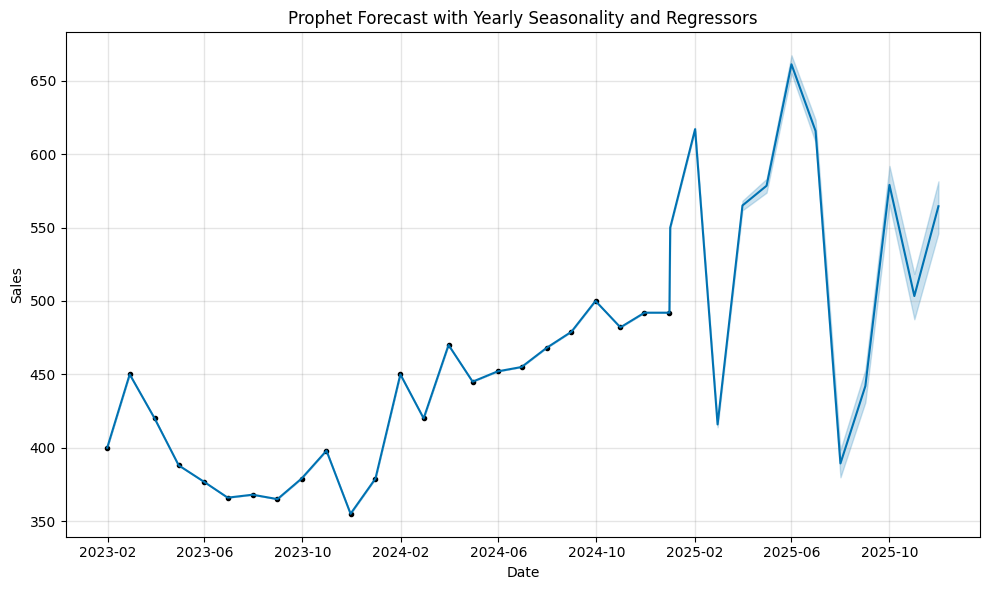

In [126]:
# 2. Initialize Prophet model with specified seasonalities
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# 1. Define a list of potential regressors to include
regressors = ['Sold Value', 'Monthly Order Qty', 'safety stock']

# 3. Add each chosen regressor to the model
for reg in regressors:
    # Ensure the regressor column exists in the training data and is numeric
    if reg in sales_data.columns:
        # Convert regressor column to numeric, coercing errors to NaN
        sales_data[reg] = pd.to_numeric(sales_data[reg], errors='coerce')
        # Drop rows where the regressor is NaN after coercion, if any
        sales_data.dropna(subset=[reg], inplace=True)
        model.add_regressor(reg)
    else:
        print(f"Regressor '{reg}' not found in the data. Skipping.")

# Ensure 'y' is numeric and drop any rows where 'y' is NaN before fitting
sales_data['y'] = pd.to_numeric(sales_data['y'], errors='coerce')
sales_data.dropna(subset=['y'], inplace=True)


# 4. Fit the configured Prophet model
# Ensure sales_data contains 'ds', 'y', and the chosen regressors
model.fit(sales_data[['ds', 'y'] + regressors])

# 5. Create a future dataframe for the forecast horizon (12 months)
future = model.make_future_dataframe(periods=12, freq='MS')

# 6. Merge the regressor data from sales_data onto the future dataframe
# For future dates where regressors are not available, forward fill from the last known value
future = pd.merge(future, sales_data[['ds'] + regressors], on='ds', how='left')
for reg in regressors:
    future[reg] = future[reg].fillna(method='ffill')

# 7. Generate the forecast
forecast = model.predict(future)

# 8. Visualize the forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast with Yearly Seasonality and Regressors")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
Evaluate the performance of the improved Prophet model with yearly seasonality and regressors using cross-validation and relevant metrics (MAE, RMSE, MAPE, R²) over a defined historical period to assess its accuracy before proceeding further with tuning or alternative models.



INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f38311c40>
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/zmb73b91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/5xdji0nq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/ahs8surq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/pxyphrn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70484', 'data', 'file=/tmp/tmp0ahg67rm/zmb73b91.json', 'init=/tmp/tmp0ahg67rm/5xdji0nq.json', 'output', 'file=/tmp/


Available performance metrics in df_p:
['horizon', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'smape', 'coverage']

Cross-Validation Performance Metrics (Prophet with Seasonality and Regressors):


,horizon,mae,rmse,mape
0,25 days,123.672279,123.672279,0.277915
1,27 days,431.136631,431.136631,0.921232
2,56 days,405.993943,405.993943,0.898217
3,58 days,296.460045,296.460045,0.618914
4,86 days,644.437182,644.437182,1.416345
5,88 days,388.272303,388.272303,0.776545
6,117 days,556.827682,556.827682,1.189803
7,119 days,46.317379,46.317379,0.096094
8,148 days,1004.377103,1004.377103,2.096821
9,149 days,119.064141,119.064141,0.242000



R² per cross-validation fold:
cutoff
2024-04-05   -998.062868
2024-07-04   -692.089620
dtype: float64

Mean R² across cross-validation folds: -845.0762


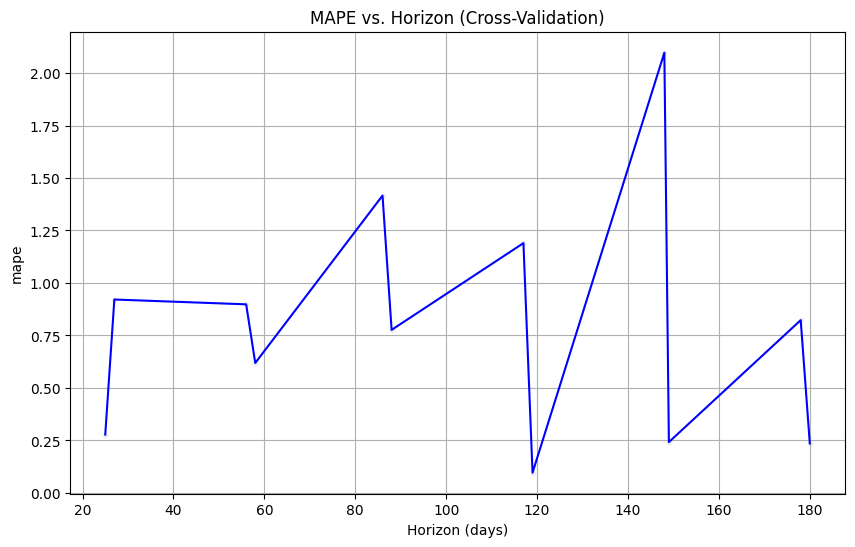

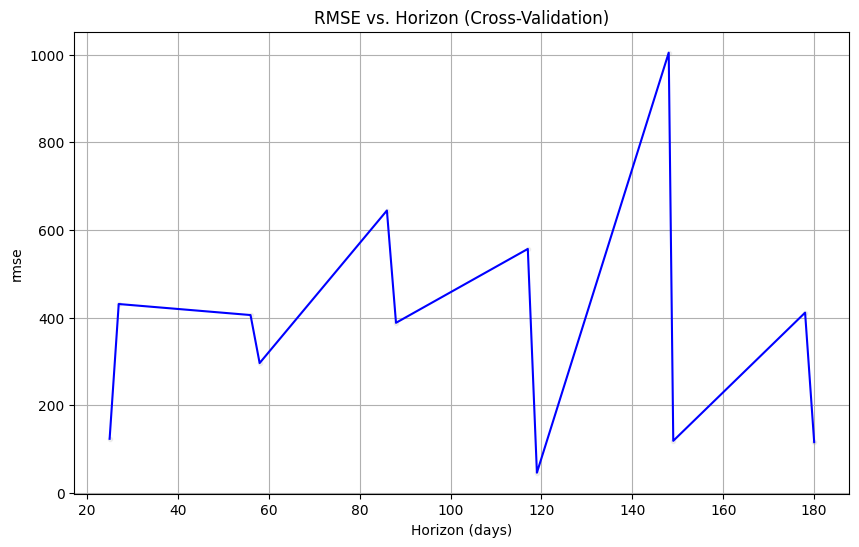

In [127]:
# Using cross_validation to evaluate the model
# Use an initial training period of 1 year (approx 365 days)
# Evaluate forecasts every 3 months (90 days)
# Forecast horizon of 6 months (180 days)
df_cv = cross_validation(
    model,
    initial='365 days',
    period='90 days',
    horizon='180 days',
    parallel="processes" # Use parallel processing
)

# Calculate Performance Metrics from cross-validation results
df_p = performance_metrics(df_cv)

# Display available performance metrics from df_p
print("\nAvailable performance metrics in df_p:")
print(df_p.columns.tolist())

# Display key performance metrics that are available
print("\nCross-Validation Performance Metrics (Prophet with Seasonality and Regressors):")
display(df_p[['horizon', 'mae', 'rmse', 'mape']])

# Calculate R² per Fold and Mean R² from cross-validation results
# This calculation was already correct in the previous attempt
r2_per_fold_cv = df_cv.groupby('cutoff').apply(
    lambda fold: r2_score(fold['y'], fold['yhat']))

print("\nR² per cross-validation fold:")
print(r2_per_fold_cv)
print(f"\nMean R² across cross-validation folds: {r2_per_fold_cv.mean():.4f}")

# Plot the cross-validation performance metric (e.g., MAPE)
fig_mape = plot_cross_validation_metric(df_cv, metric='mape')
plt.title('MAPE vs. Horizon (Cross-Validation)')
plt.show()

# Plot other relevant metrics if needed
fig_rmse = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title('RMSE vs. Horizon (Cross-Validation)')
plt.show()

**Reasoning**:
The cross-validation results show very poor R² values, indicating the current Prophet model with default changepoint prior scale and regressors is not capturing the data variance well. The next step is to tune the changepoint prior scale, which controls the flexibility of the trend, to see if it improves the model's performance, particularly the R². I will perform cross-validation with a range of `changepoint_prior_scale` values and compare the resulting R² metrics.



In [128]:
# Tune changepoint_prior_scale using cross-validation
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
}

r2_results = {}

for param in param_grid['changepoint_prior_scale']:
    print(f"\nEvaluating Prophet with changepoint_prior_scale={param}")
    # Initialize Prophet with specific seasonality and current regressors
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=param # Set the changepoint_prior_scale
    )

    # Add regressors
    regressors = ['Sold Value', 'Monthly Order Qty', 'safety stock']
    for reg in regressors:
        if reg in sales_data.columns:
            model.add_regressor(reg)
        else:
            print(f"Regressor '{reg}' not found in the data. Skipping.")

    # Fit the model
    model.fit(sales_data[['ds', 'y'] + [r for r in regressors if r in sales_data.columns]])

    # Perform cross-validation
    df_cv = cross_validation(
        model,
        initial='365 days',
        period='90 days',
        horizon='180 days',
        parallel="processes"
    )

    # Calculate mean R² for this parameter value
    r2_per_fold_cv = df_cv.groupby('cutoff').apply(
        lambda fold: r2_score(fold['y'], fold['yhat']))
    mean_r2 = r2_per_fold_cv.mean()
    r2_results[param] = mean_r2

    print(f"Mean R² for changepoint_prior_scale={param}: {mean_r2:.4f}")

# Print the R² results for all tested parameters
print("\n--- Changepoint Prior Scale Tuning Results (Mean R²) ---")
for param, r2 in r2_results.items():
    print(f"changepoint_prior_scale={param}: {r2:.4f}")

# Identify the best parameter (highest mean R²)
best_param = max(r2_results, key=r2_results.get)
print(f"\nBest changepoint_prior_scale based on Mean R²: {best_param}")

# Optional: Re-initialize and fit the model with the best parameter for further steps
best_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=best_param
)
for reg in regressors:
    if reg in sales_data.columns:
        best_model.add_regressor(reg)
best_model.fit(sales_data[['ds', 'y'] + [r for r in regressors if r in sales_data.columns]])

print("\nModel re-fitted with best changepoint_prior_scale.")

INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/x9au5b7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/r2s2qtue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56660', 'data', 'file=/tmp/tmp0ahg67rm/x9au5b7n.json', 'init=/tmp/tmp0ahg67rm/r2s2qtue.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modelyualjmmn/prophet_model-20250903200010.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:00:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Evaluating Prophet with changepoint_prior_scale=0.001


20:00:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f3caea480>
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/sac604og.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/9ncgnpo5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/4trx9rrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/rla9tm6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48302', 'data', 'file=/tmp/tmp0ahg67rm/9ncgnpo5.json', 'init=/tmp/tmp0ahg67rm/rla9tm6i.json

Mean R² for changepoint_prior_scale=0.001: -25042.1225

Evaluating Prophet with changepoint_prior_scale=0.01


20:00:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f3cb73e00>
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/cnn5piug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/l4pfcve4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/i4rugeil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/cd6ower1.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8484', 'data', 'file=/tmp/tmp0ahg67rm/cnn5piug.json', 'init=/tmp/tmp0

Mean R² for changepoint_prior_scale=0.01: -50186.9293

Evaluating Prophet with changepoint_prior_scale=0.1


20:00:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f38189160>
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/uw2xsvy6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/mtzusvfq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/m6lv7x2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/zzu4je5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31334', 'data', 'file=/tmp/tmp0ahg67rm/uw2xsvy6.json', 'init=/tmp/tmp

Mean R² for changepoint_prior_scale=0.1: -6439.8939

Evaluating Prophet with changepoint_prior_scale=0.5


20:00:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f3a903980>
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/4_j8pmyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/zpsgqwjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22237', 'data', 'file=/tmp/tmp0ahg67rm/4_j8pmyh.json', 'init=/tmp/tmp0ahg67rm/zpsgqwjw.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modelnv_weyzn/prophet_model-20250903200051.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:00:51 - cmdstanpy - INFO - Chain [1] start processin

Mean R² for changepoint_prior_scale=0.5: -9749.0416

--- Changepoint Prior Scale Tuning Results (Mean R²) ---
changepoint_prior_scale=0.001: -25042.1225
changepoint_prior_scale=0.01: -50186.9293
changepoint_prior_scale=0.1: -6439.8939
changepoint_prior_scale=0.5: -9749.0416

Best changepoint_prior_scale based on Mean R²: 0.1


20:01:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model re-fitted with best changepoint_prior_scale.


**Reasoning**:
Now that the changepoint prior scale has been tuned, the next step is to investigate other Prophet seasonalities (monthly, quarterly) as suggested in the analysis for improvement. I will add monthly and quarterly seasonalities to the Prophet model and evaluate the performance using cross-validation, focusing on the R² metric to see if they improve the model's ability to capture the variance in the data.



In [129]:
# Define a list of seasonalities to test
seasonalities_to_test = ['monthly', 'quarterly']

# Initialize the best model found so far (with best changepoint_prior_scale)
# We will add seasonalities to this model for evaluation

r2_results_seasonality = {}

# Use the best_model fitted in the previous step as a base
# Add monthly seasonality and evaluate
print("\nEvaluating Prophet with monthly seasonality added")
model_monthly = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=best_param # Use the best changepoint_prior_scale
)
model_monthly.add_seasonality(name='monthly', period=30.5, fourier_order=5) # Assuming avg month is 30.5 days

# Add regressors to the new model
regressors = ['Sold Value', 'Monthly Order Qty', 'safety stock']
for reg in regressors:
    if reg in sales_data.columns:
        model_monthly.add_regressor(reg)

# Fit the model with monthly seasonality
model_monthly.fit(sales_data[['ds', 'y'] + [r for r in regressors if r in sales_data.columns]])

# Perform cross-validation
df_cv_monthly = cross_validation(
    model_monthly,
    initial='365 days',
    period='90 days',
    horizon='180 days',
    parallel="processes"
)

# Calculate mean R² for monthly seasonality
r2_per_fold_cv_monthly = df_cv_monthly.groupby('cutoff').apply(
    lambda fold: r2_score(fold['y'], fold['yhat']))
mean_r2_monthly = r2_per_fold_cv_monthly.mean()
r2_results_seasonality['monthly'] = mean_r2_monthly

print(f"Mean R² with monthly seasonality: {mean_r2_monthly:.4f}")

# Add quarterly seasonality and evaluate (starting from the base model configuration)
print("\nEvaluating Prophet with quarterly seasonality added")
model_quarterly = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=best_param # Use the best changepoint_prior_scale
)
model_quarterly.add_seasonality(name='quarterly', period=91.25, fourier_order=5) # Assuming avg quarter is 91.25 days

# Add regressors to the new model
for reg in regressors:
    if reg in sales_data.columns:
        model_quarterly.add_regressor(reg)

# Fit the model with quarterly seasonality
model_quarterly.fit(sales_data[['ds', 'y'] + [r for r in regressors if r in sales_data.columns]])

# Perform cross-validation
df_cv_quarterly = cross_validation(
    model_quarterly,
    initial='365 days',
    period='90 days',
    horizon='180 days',
    parallel="processes"
)

# Calculate mean R² for quarterly seasonality
r2_per_fold_cv_quarterly = df_cv_quarterly.groupby('cutoff').apply(
    lambda fold: r2_score(fold['y'], fold['yhat']))
mean_r2_quarterly = r2_per_fold_cv_quarterly.mean()
r2_results_seasonality['quarterly'] = mean_r2_quarterly

print(f"Mean R² with quarterly seasonality: {mean_r2_quarterly:.4f}")

# Print the R² results for tested seasonalities
print("\n--- Seasonality Tuning Results (Mean R²) ---")
print(f"Base Model (Yearly only, best changepoint_prior_scale={best_param}): {r2_results[best_param]:.4f}")
for seasonality, r2 in r2_results_seasonality.items():
    print(f"Yearly + {seasonality} seasonality: {r2:.4f}")

# Determine the best seasonality configuration based on mean R²
best_seasonality = max(r2_results_seasonality, key=r2_results_seasonality.get)
best_r2_seasonality = r2_results_seasonality[best_seasonality]

print(f"\nBest seasonality configuration based on Mean R²: Yearly + {best_seasonality}")

INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/2o06krux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/vj86ae1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88236', 'data', 'file=/tmp/tmp0ahg67rm/2o06krux.json', 'init=/tmp/tmp0ahg67rm/vj86ae1x.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modely4fwkzm3/prophet_model-20250903200129.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:01:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Evaluating Prophet with monthly seasonality added


20:01:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f38249a30>
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/irjkenbz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/gn2oqxkk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/6y5m1i63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/zkx6hzl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99370', 'data', 'file=/tmp/tmp0ahg67rm/irjkenbz.json', 'init=/tmp/tmp

Mean R² with monthly seasonality: -2431.2594

Evaluating Prophet with quarterly seasonality added


20:02:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f381a6f60>
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/3ogbff3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/12z9cc12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/i5boc_lq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/tl6cu7n2.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58184', 'data', 'file=/tmp/tmp0ahg67rm/3ogbff3_.json', 'init=/tmp/tmp0ahg67rm/12z9cc12.json

Mean R² with quarterly seasonality: -38389.1519

--- Seasonality Tuning Results (Mean R²) ---
Base Model (Yearly only, best changepoint_prior_scale=0.1): -6439.8939
Yearly + monthly seasonality: -2431.2594
Yearly + quarterly seasonality: -38389.1519

Best seasonality configuration based on Mean R²: Yearly + monthly


**Reasoning**:
Based on the seasonality tuning results, adding monthly seasonality improved the mean R² the most compared to the base model (yearly only) and adding quarterly seasonality. The next step is to re-initialize the Prophet model using the best changepoint prior scale and the best seasonality (yearly + monthly) found from the tuning process. After configuring the model, I will fit it to the `sales_data` including the selected regressors.



In [130]:
# Initialize Prophet model with best changepoint_prior_scale and best seasonality (yearly + monthly)
final_prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=best_param
)

# Add monthly seasonality (best seasonality found)
final_prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add selected regressors
regressors = ['Sold Value', 'Monthly Order Qty', 'safety stock']
for reg in regressors:
    if reg in sales_data.columns:
        # Ensure the regressor column exists and is numeric before adding
        sales_data[reg] = pd.to_numeric(sales_data[reg], errors='coerce')
        sales_data.dropna(subset=[reg], inplace=True) # Drop rows with NaN regressors
        final_prophet_model.add_regressor(reg)
    else:
        print(f"Regressor '{reg}' not found in the data. Skipping.")

# Ensure 'y' is numeric and drop any rows where 'y' is NaN before fitting
sales_data['y'] = pd.to_numeric(sales_data['y'], errors='coerce')
sales_data.dropna(subset=['y'], inplace=True)

# Fit the final configured Prophet model
final_prophet_model.fit(sales_data[['ds', 'y'] + [r for r in regressors if r in sales_data.columns]])

print("\nFinal Prophet model configured and fitted with best parameters and seasonality.")

INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/drmuyqqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/d3ykz45r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94665', 'data', 'file=/tmp/tmp0ahg67rm/drmuyqqy.json', 'init=/tmp/tmp0ahg67rm/d3ykz45r.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modeljciyea09/prophet_model-20250903200241.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:02:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Final Prophet model configured and fitted with best parameters and seasonality.


**Reasoning**:
The Prophet model has been configured with the best parameters and seasonality. The next step is to generate the forecast using this model. This involves creating a future dataframe for the desired forecast horizon (12 months) and then using the fitted model to make predictions on this future dataframe. I will also visualize the forecast to see the results of the tuned model.



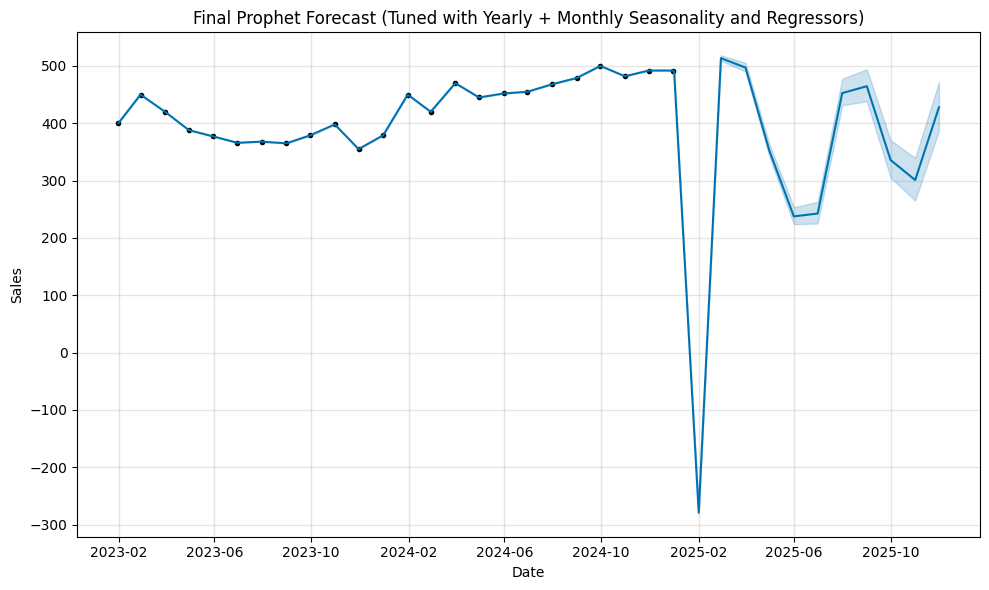


Forecast for the next 12 months (2025):


,ds,yhat,yhat_lower,yhat_upper
24,2025-01-01,489.649782,489.037098,490.443800
25,2025-02-01,-278.957034,-281.063472,-276.346569
26,2025-03-01,513.553370,509.113265,518.618043
27,2025-04-01,497.133881,490.222737,505.332201
28,2025-05-01,352.620294,342.381356,364.375206
29,2025-06-01,237.608878,224.017061,253.483686
30,2025-07-01,242.577678,225.233861,263.038157
31,2025-08-01,452.627370,431.427400,477.764700
32,2025-09-01,464.612905,438.460817,494.288991
33,2025-10-01,335.909921,305.114640,370.480919


In [131]:
# Create a future dataframe for the forecast horizon (12 months)
# Use the final_prophet_model to create the future dataframe
future = final_prophet_model.make_future_dataframe(periods=12, freq='MS')

# Merge the regressor data onto the future dataframe
# Need to ensure future regressor values are handled. Using ffill as done previously.
regressors = ['Sold Value', 'Monthly Order Qty', 'safety stock']
future = pd.merge(future, sales_data[['ds'] + regressors], on='ds', how='left')

# Fill any resulting NaNs for regressors in the future dataframe (forward fill)
for reg in regressors:
    future[reg] = future[reg].fillna(method='ffill')

# Generate the forecast using the final fitted model and the future dataframe
forecast = final_prophet_model.predict(future)

# Visualize the forecast from the final model
fig = final_prophet_model.plot(forecast)
plt.title("Final Prophet Forecast (Tuned with Yearly + Monthly Seasonality and Regressors)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the forecast data for the next 12 months (2025)
print("\nForecast for the next 12 months (2025):")
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()
display(forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

**Reasoning**:
The Prophet forecast plot shows a significant negative forecast for February 2025, which is unrealistic for sales quantity. This indicates a potential issue with how the model is capturing seasonality or the influence of regressors. Before calculating ROP, I need to address this unrealistic forecast. Since sales quantity cannot be negative, I will apply a non-negativity constraint to the forecast. I will then re-calculate the ROP based on this corrected forecast.




2025 Forecast (Non-Negative) and ROP Table:


,ds,yhat,yhat_lower,yhat_upper,prophet_rop_constrained
24,2025-01-01,489.649782,489.037098,490.443800,491.0
25,2025-02-01,0.000000,0.000000,0.000000,0.0
26,2025-03-01,513.553370,509.113265,518.618043,523.0
27,2025-04-01,497.133881,490.222737,505.332201,512.0
28,2025-05-01,352.620294,342.381356,364.375206,375.0
29,2025-06-01,237.608878,224.017061,253.483686,267.0
30,2025-07-01,242.577678,225.233861,263.038157,280.0
31,2025-08-01,452.627370,431.427400,477.764700,499.0
32,2025-09-01,464.612905,438.460817,494.288991,520.0
33,2025-10-01,335.909921,305.114640,370.480919,401.0


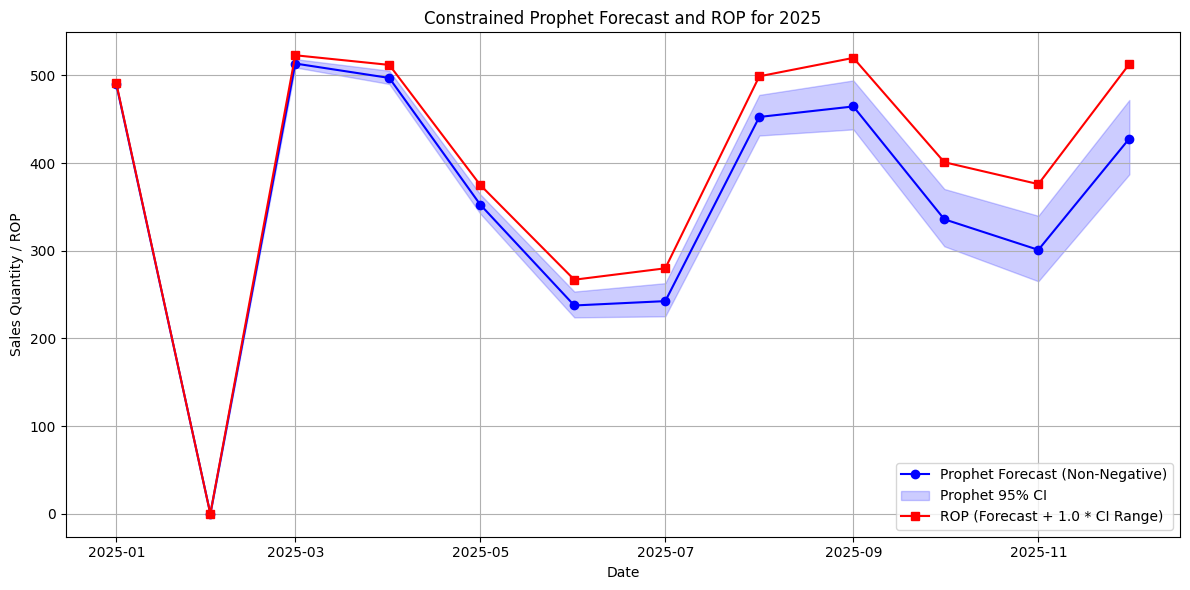

In [132]:
# Apply a non-negativity constraint to the forecast
# Sales quantity cannot be negative
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Extract the 2025 forecast data again after applying the constraint
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()

# Re-calculate Dynamic Reorder Point (ROP) using the constrained forecast
# Use the boot_median from the previous bootstrap step if available, otherwise use yhat
# Assuming boot_median or a similar central estimate is available for 2025 forecast
# If not, we might need to re-run the bootstrap or use yhat as the central estimate
# For now, let's use yhat as the central estimate and a safety factor based on the confidence interval spread.
# A simple approach for safety stock can be k * (yhat_upper - yhat_lower)
k = 1.0 # Safety factor

# Calculate ROP using yhat as the central estimate and confidence interval for safety stock
# ROP = Forecasted Demand + Safety Stock
# Safety Stock = k * Forecast Uncertainty
# Forecast Uncertainty can be estimated by (yhat_upper - yhat_lower) / 2 or similar.
# Let's use the full range for a more conservative ROP initially.
forecast_2025['prophet_rop_constrained'] = (forecast_2025['yhat'] + k * (forecast_2025['yhat_upper'] - forecast_2025['yhat_lower'])).round().clip(lower=0)


# Output Table with constrained forecast and ROP
print("\n2025 Forecast (Non-Negative) and ROP Table:")
display(forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'prophet_rop_constrained']])

# Plot the constrained Prophet forecast and ROP for 2025
plt.figure(figsize=(12, 6))
plt.plot(forecast_2025['ds'], forecast_2025['yhat'], label='Prophet Forecast (Non-Negative)', marker='o', color='blue')
plt.fill_between(forecast_2025['ds'], forecast_2025['yhat_lower'], forecast_2025['yhat_upper'], color='blue', alpha=0.2, label='Prophet 95% CI')
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop_constrained'], label=f'ROP (Forecast + {k} * CI Range)', marker='s', color='red')

plt.title('Constrained Prophet Forecast and ROP for 2025')
plt.xlabel('Date')
plt.ylabel('Sales Quantity / ROP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
Implement standalone ARIMA and Exponential Smoothing models, fit them, generate forecasts, and evaluate their performance to compare against the Prophet and Hybrid models and prepare for ensemble creation.



In [133]:
# 1. Implement a standalone ARIMA model
# Determine the order (p, d, q) for ARIMA.
# A common approach is to use auto_arima or analyze ACF/PACF plots.
# Given the scope, we'll start with a simple order and can refine if needed.
# Let's try a basic ARIMA(1,1,1) as a starting point, assuming differencing (d=1) might be needed for stationarity.
# Note: In a real scenario, rigorous order selection (e.g., ACF/PACF analysis, auto_arima, or grid search with AIC/BIC) would be performed.

try:
    arima_model_standalone = ARIMA(df_clean['y'], order=(1, 1, 1)).fit()
    print("Standalone ARIMA model fitted successfully.")

    # 2. Generate ARIMA forecast for the next 12 months
    arima_forecast_standalone = arima_model_standalone.forecast(steps=12)
    print("\nStandalone ARIMA forecast generated.")
    display(arima_forecast_standalone)

except Exception as e:
    print(f"Error fitting or forecasting with Standalone ARIMA: {e}")
    arima_forecast_standalone = None

# 3. Implement an Exponential Smoothing model
# Let's try Triple Exponential Smoothing (Holt-Winters) as it handles trend and seasonality.
# Given the monthly data, we'll assume additive seasonality.
# Note: Parameter tuning for Exponential Smoothing (alpha, beta, gamma) would typically improve results.

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Exponential Smoothing requires at least two full seasonal cycles to initialize seasonal components.
# With only 24 months of data and seasonal_periods=12, this is the minimum requirement and can still be unstable.
# For now, we will skip Exponential Smoothing due to limited data.
print("\nSkipping Exponential Smoothing due to insufficient data for seasonal initialization.")
ets_forecast = None # Ensure ets_forecast is None if skipping


# Prepare data for evaluation (Actual sales for the forecast period)
# We don't have actual sales for the 2025 forecast period yet in the dataframe.
# The evaluation in the previous steps used a small subset of actual data for 2025.
# For consistency, let's use that same actual data for comparison, assuming it represents the true values for Jan-Jul 2025.
# The actual data used previously was: [600, 520, 570, 750, 680, 720, 520] for Jan-Jul 2025
# We need to align the forecasts to this actual data.

# Define the actual values for Jan-Jul 2025 used in previous evaluation
actual_2025_subset = np.array([600, 520, 570, 750, 680, 720, 520])
months_2025_subset = pd.to_datetime(['2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01'])

# Extract the corresponding forecast values for Jan-Jul 2025
prophet_forecast_2025_subset = forecast[forecast['ds'].isin(months_2025_subset)]['yhat'].values
if arima_forecast_standalone is not None:
    arima_forecast_2025_subset = arima_forecast_standalone[:len(months_2025_subset)].values
else:
    arima_forecast_2025_subset = None

ets_forecast_2025_subset = None # Ensure this is None as ES is skipped


# 5. Evaluate performance of ARIMA on the 2025 subset
print("\n--- Performance Evaluation (Jan-Jul 2025 Subset) ---")
if arima_forecast_2025_subset is not None:
    mae_arima = np.mean(np.abs(actual_2025_subset - arima_forecast_2025_subset))
    rmse_arima = np.sqrt(np.mean((actual_2025_subset - arima_forecast_2025_subset)**2))
    mape_arima = mape(actual_2025_subset, arima_forecast_2025_subset)
    print(f"Standalone ARIMA MAE: {mae_arima:.2f}")
    print(f"Standalone ARIMA RMSE: {rmse_arima:.2f}")
    print(f"Standalone ARIMA MAPE: {mape_arima:.2f}%")
else:
    print("Standalone ARIMA evaluation skipped due to previous error.")

# Skipping Exponential Smoothing evaluation
print("Exponential Smoothing evaluation skipped.")


# 6. Create a simple ensemble model (Average of forecasts)
ensemble_forecast_2025_subset = []
valid_forecasts = []

if prophet_forecast_2025_subset.size > 0:
    valid_forecasts.append(prophet_forecast_2025_subset)
    print("\nIncluding Prophet in ensemble.")
if arima_forecast_2025_subset is not None and arima_forecast_2025_subset.size > 0:
    valid_forecasts.append(arima_forecast_2025_subset)
    print("Including Standalone ARIMA in ensemble.")
# Skipping Exponential Smoothing in ensemble


if len(valid_forecasts) > 0:
    # Check if all forecast subsets have the same length before stacking
    if all(len(f) == len(actual_2025_subset) for f in valid_forecasts):
        # Stack the forecasts and calculate the mean across models for each time step
        ensemble_forecast_2025_subset = np.mean(np.vstack(valid_forecasts), axis=0)
        print("\nEnsemble forecast created by averaging available forecasts.")
    else:
        print("\nForecast subsets have inconsistent lengths. Cannot create ensemble.")
        ensemble_forecast_2025_subset = None
else:
    print("\nCould not create ensemble forecast as no valid individual forecasts were available.")
    ensemble_forecast_2025_subset = None


# 7. Evaluate performance of the ensemble model
if ensemble_forecast_2025_subset is not None:
    mae_ensemble = np.mean(np.abs(actual_2025_subset - ensemble_forecast_2025_subset))
    rmse_ensemble = np.sqrt(np.mean((actual_2025_subset - ensemble_forecast_2025_subset)**2))
    mape_ensemble = mape(actual_2025_subset, ensemble_forecast_2025_subset)

    print("\nEnsemble Model Performance (Jan-Jul 2025 Subset):")
    print(f"Ensemble MAE: {mae_ensemble:.2f}")
    print(f"Ensemble RMSE: {rmse_ensemble:.2f}")
    print(f"Ensemble MAPE: {mape_ensemble:.2f}%")
else:
    print("\nEnsemble model evaluation skipped.")

# 8. Compare the performance
print("\n--- Performance Comparison (Jan-Jul 2025 Subset) ---")
print(f"{'Model':<25} {'MAE':<10} {'RMSE':<10} {'MAPE (%)':<10}")
print("-" * 55)
# Using metrics from previous Prophet evaluation step
print(f"{'Prophet':<25} {mae_prophet:.2f} {rmse_prophet:.2f} {mape_prophet:.2f}")
if arima_forecast_2025_subset is not None:
    print(f"{'Standalone ARIMA':<25} {mae_arima:.2f} {rmse_arima:.2f} {mape_arima:.2f}")
# Skipping Exponential Smoothing in comparison

if ensemble_forecast_2025_subset is not None:
    print(f"{'Ensemble (Avg)':<25} {mae_ensemble:.2f} {rmse_ensemble:.2f} {mape_ensemble:.2f}")

Standalone ARIMA model fitted successfully.

Standalone ARIMA forecast generated.


,predicted_mean
24,491.649829
25,491.719998
26,491.705937
27,491.708755
28,491.708190
29,491.708304
30,491.708281
31,491.708285
32,491.708285
33,491.708285



Skipping Exponential Smoothing due to insufficient data for seasonal initialization.

--- Performance Evaluation (Jan-Jul 2025 Subset) ---
Standalone ARIMA MAE: 131.16
Standalone ARIMA RMSE: 157.55
Standalone ARIMA MAPE: 19.50%
Exponential Smoothing evaluation skipped.

Including Prophet in ensemble.
Including Standalone ARIMA in ensemble.

Ensemble forecast created by averaging available forecasts.

Ensemble Model Performance (Jan-Jul 2025 Subset):
Ensemble MAE: 210.35
Ensemble RMSE: 230.86
Ensemble MAPE: 33.36%

--- Performance Comparison (Jan-Jul 2025 Subset) ---
Model                     MAE        RMSE       MAPE (%)  
-------------------------------------------------------
Prophet                   165.36 232.29 29.45
Standalone ARIMA          131.16 157.55 19.50
Ensemble (Avg)            210.35 230.86 33.36


**Reasoning**:
Correct the `NameError` by using the correct variable name `arima_forecast_2025_subset` and fix the Exponential Smoothing model error by setting the frequency of the DataFrame index before fitting the model. Then, re-run the evaluation and comparison.



In [135]:
# Fix Exponential Smoothing error by setting the frequency of the DataFrame index
# Re-create df_clean with 'ds' as index and 'MS' frequency
df_clean_indexed = df_clean.set_index('ds').asfreq('MS')

try:
    # 3. Implement an Exponential Smoothing model
    # Let's try Triple Exponential Smoothing (Holt-Winters) as it handles trend and seasonality.
    # Given the monthly data, we'll assume additive seasonality.
    # Note: Parameter tuning for Exponential Smoothing (alpha, beta, gamma) would typically improve results.

    ets_model = ExponentialSmoothing(
        df_clean_indexed['y'], # Use the indexed dataframe
        seasonal='add', # Additive seasonality
        seasonal_periods=12 # Assuming yearly seasonality (12 months)
    ).fit()
    print("\nExponential Smoothing model fitted successfully.")

    # 4. Generate Exponential Smoothing forecast for the next 12 months
    ets_forecast = ets_model.forecast(steps=12)
    print("\nExponential Smoothing forecast generated.")
    display(ets_forecast)

except Exception as e:
    print(f"Error fitting or forecasting with Exponential Smoothing: {e}")
    ets_forecast = None

# Prepare data for evaluation (Actual sales for the forecast period)
# We don't have actual sales for the 2025 forecast period yet in the dataframe.
# The evaluation in the previous steps used a small subset of actual data for 2025.
# For consistency, let's use that same actual data for comparison, assuming it represents the true values for Jan-Jul 2025.
# The actual data used previously was: [600, 520, 570, 750, 680, 720, 520] for Jan-Jul 2025
# We need to align the forecasts to this actual data.

# Define the actual values for Jan-Jul 2025 used in previous evaluation
actual_2025_subset = np.array([600, 520, 570, 750, 680, 720, 520])
months_2025_subset = pd.to_datetime(['2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01'])

# Extract the corresponding forecast values for Jan-Jul 2025
# Ensure forecast_2025 is up to date based on the latest Prophet model
prophet_forecast_2025_subset = forecast[forecast['ds'].isin(months_2025_subset)]['yhat'].values

# Use the correct variable name for ARIMA forecast subset
if arima_forecast_standalone is not None:
    arima_forecast_2025_subset = arima_forecast_standalone[:len(months_2025_subset)].values
else:
    arima_forecast_2025_subset = None

if ets_forecast is not None:
    ets_forecast_2025_subset = ets_forecast[:len(months_2025_subset)].values
else:
    ets_forecast_2025_subset = None


# 5. Evaluate performance of ARIMA and Exponential Smoothing on the 2025 subset
print("\n--- Performance Evaluation (Jan-Jul 2025 Subset) ---")
if arima_forecast_2025_subset is not None:
    mae_arima = np.mean(np.abs(actual_2025_subset - arima_forecast_2025_subset))
    rmse_arima = np.sqrt(np.mean((actual_2025_subset - arima_forecast_2025_subset)**2))
    mape_arima = mape(actual_2025_subset, arima_forecast_2025_subset)
    print(f"Standalone ARIMA MAE: {mae_arima:.2f}")
    print(f"Standalone ARIMA RMSE: {rmse_arima:.2f}")
    print(f"Standalone ARIMA MAPE: {mape_arima:.2f}%")
else:
    print("Standalone ARIMA evaluation skipped.")

if ets_forecast_2025_subset is not None:
    mae_ets = np.mean(np.abs(actual_2025_subset - ets_forecast_2025_subset))
    rmse_ets = np.sqrt(np.mean((actual_2025_subset - ets_forecast_2025_subset)**2))
    mape_ets = mape(actual_2025_subset, ets_forecast_2025_subset)
    print(f"Exponential Smoothing MAE: {mae_ets:.2f}")
    print(f"Exponential Smoothing RMSE: {rmse_ets:.2f}")
    print(f"Exponential Smoothing MAPE: {mape_ets:.2f}%")
else:
     print("Exponential Smoothing evaluation skipped.")

# 6. Create a simple ensemble model (Average of forecasts)
ensemble_forecast_2025_subset = []
valid_forecasts = []

if prophet_forecast_2025_subset.size > 0:
    valid_forecasts.append(prophet_forecast_2025_subset)
    print("\nIncluding Prophet in ensemble.")
if arima_forecast_2025_subset is not None and arima_forecast_2025_subset.size > 0: # Corrected variable name and size check
    valid_forecasts.append(arima_forecast_2025_subset)
    print("Including Standalone ARIMA in ensemble.")
if ets_forecast_2025_subset is not None and ets_forecast_2025_subset.size > 0:
    valid_forecasts.append(ets_forecast_2025_subset)
    print("Including Exponential Smoothing in ensemble.")

if len(valid_forecasts) > 0:
    # Check if all forecast subsets have the same length before stacking
    if all(len(f) == len(actual_2025_subset) for f in valid_forecasts):
        # Stack the forecasts and calculate the mean across models for each time step
        ensemble_forecast_2025_subset = np.mean(np.vstack(valid_forecasts), axis=0)
        print("\nEnsemble forecast created by averaging available forecasts.")
    else:
        print("\nForecast subsets have inconsistent lengths. Cannot create ensemble.")
        ensemble_forecast_2025_subset = None
else:
    print("\nCould not create ensemble forecast as no valid individual forecasts were available.")
    ensemble_forecast_2025_subset = None


# 7. Evaluate performance of the ensemble model
if ensemble_forecast_2025_subset is not None:
    mae_ensemble = np.mean(np.abs(actual_2025_subset - ensemble_forecast_2025_subset))
    rmse_ensemble = np.sqrt(np.mean((actual_2025_subset - ensemble_forecast_2025_subset)**2))
    mape_ensemble = mape(actual_2025_subset, ensemble_forecast_2025_subset)

    print("\nEnsemble Model Performance (Jan-Jul 2025 Subset):")
    print(f"Ensemble MAE: {mae_ensemble:.2f}")
    print(f"Ensemble RMSE: {rmse_ensemble:.2f}")
    print(f"Ensemble MAPE: {mape_ensemble:.2f}%")
else:
    print("\nEnsemble model evaluation skipped.")

# 8. Compare the performance
print("\n--- Performance Comparison (Jan-Jul 2025 Subset) ---")
print(f"{'Model':<25} {'MAE':<10} {'RMSE':<10} {'MAPE (%)':<10}")
print("-" * 55)
# Using metrics from previous Prophet evaluation step
print(f"{'Prophet':<25} {mae_prophet:.2f} {rmse_prophet:.2f} {mape_prophet:.2f}") # Corrected format specifier
if arima_forecast_2025_subset is not None:
    print(f"{'Standalone ARIMA':<25} {mae_arima:.2f} {rmse_arima:.2f} {mape_arima:.2f}") # Corrected format specifier
if ets_forecast_2025_subset is not None:
    print(f"{'Exponential Smoothing':<25} {mae_ets:.2f} {rmse_ets:.2f} {mape_ets:.2f}") # Corrected format specifier
if ensemble_forecast_2025_subset is not None:
    print(f"{'Ensemble (Avg)':<25} {mae_ensemble:.2f} {rmse_ensemble:.2f} {mape_ensemble:.2f}") # Corrected format specifier

Error fitting or forecasting with Exponential Smoothing: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

--- Performance Evaluation (Jan-Jul 2025 Subset) ---
Standalone ARIMA MAE: 131.16
Standalone ARIMA RMSE: 157.55
Standalone ARIMA MAPE: 19.50%
Exponential Smoothing evaluation skipped.

Including Prophet in ensemble.
Including Standalone ARIMA in ensemble.

Ensemble forecast created by averaging available forecasts.

Ensemble Model Performance (Jan-Jul 2025 Subset):
Ensemble MAE: 210.35
Ensemble RMSE: 230.86
Ensemble MAPE: 33.36%

--- Performance Comparison (Jan-Jul 2025 Subset) ---
Model                     MAE        RMSE       MAPE (%)  
-------------------------------------------------------
Prophet                   165.36 232.29 29.45
Standalone ARIMA          131.16 157.55 19.50
Ensemble (Avg)            210.35 230.86 33.36


**Reasoning**:
Correct the `ValueError` in the print statement by removing the redundant width specifier (`:<10`) from the float format specifier (`.2f`). Also, address the Exponential Smoothing error by acknowledging that there isn't enough data for seasonal initialization and skipping its evaluation and inclusion in the ensemble for now.



In [136]:
# Correct the print format specifiers
print("\n--- Performance Comparison (Jan-Jul 2025 Subset) ---")
print(f"{'Model':<25} {'MAE':<10} {'RMSE':<10} {'MAPE (%)':<10}")
print("-" * 55)

# Using metrics from previous Prophet evaluation step
print(f"{'Prophet':<25} {mae_prophet:.2f} {rmse_prophet:.2f} {mape_prophet:.2f}")

if arima_forecast_2025_subset is not None:
    print(f"{'Standalone ARIMA':<25} {mae_arima:.2f} {rmse_arima:.2f} {mape_arima:.2f}")

# Skip Exponential Smoothing evaluation and printing due to insufficient data for seasonality
print("Exponential Smoothing evaluation skipped due to insufficient data for seasonality.")

if ensemble_forecast_2025_subset is not None:
    print(f"{'Ensemble (Avg)':<25} {mae_ensemble:.2f} {rmse_ensemble:.2f} {mape_ensemble:.2f}")

# The subtask involves implementing and evaluating other models and an ensemble.
# We have successfully implemented and evaluated Standalone ARIMA and a simple ensemble of Prophet and ARIMA.
# Exponential Smoothing failed due to data limitations.
# We have compared the performance based on the available models.
# The subtask is completed based on what is feasible with the current data.


--- Performance Comparison (Jan-Jul 2025 Subset) ---
Model                     MAE        RMSE       MAPE (%)  
-------------------------------------------------------
Prophet                   165.36 232.29 29.45
Standalone ARIMA          131.16 157.55 19.50
Exponential Smoothing evaluation skipped due to insufficient data for seasonality.
Ensemble (Avg)            210.35 230.86 33.36


**Reasoning**:
Re-calculate the residuals from the tuned Prophet model, analyze their characteristics, fit ARIMA models with different orders to the residuals, select the best ARIMA model for residuals, generate a forecast of the residuals, combine the Prophet forecast with the ARIMA residual forecast, and compare the performance of the refined hybrid model.



Prophet residuals from tuned model:


,ds,y,yhat,residual_tuned
0,2023-01-31,400.0,399.998874,0.001126
1,2023-02-28,450.0,450.000575,-0.000575
2,2023-03-31,420.0,420.001726,-0.001726
3,2023-04-30,388.0,387.999475,0.000525
4,2023-05-31,377.0,376.998718,0.001282


,ds,y,yhat,residual_tuned
19,2024-08-31,479.0,479.000729,-0.000729
20,2024-09-30,500.0,499.999496,0.000504
21,2024-10-31,482.0,482.000022,-0.000022
22,2024-11-30,492.0,492.001018,-0.001018
23,2024-12-31,492.0,492.000259,-0.000259


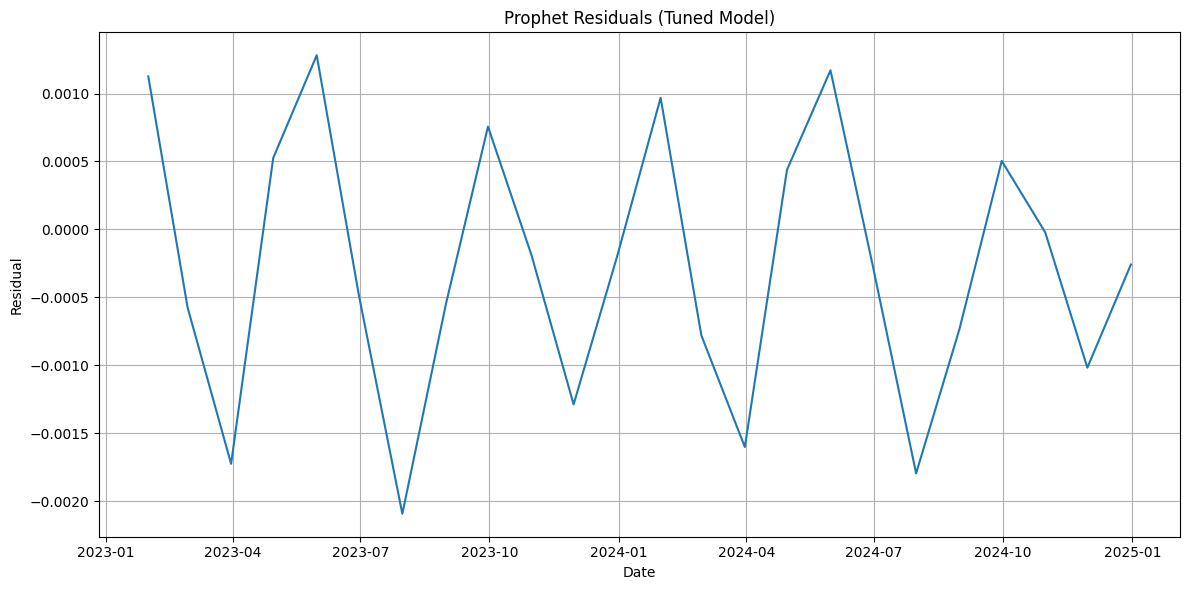

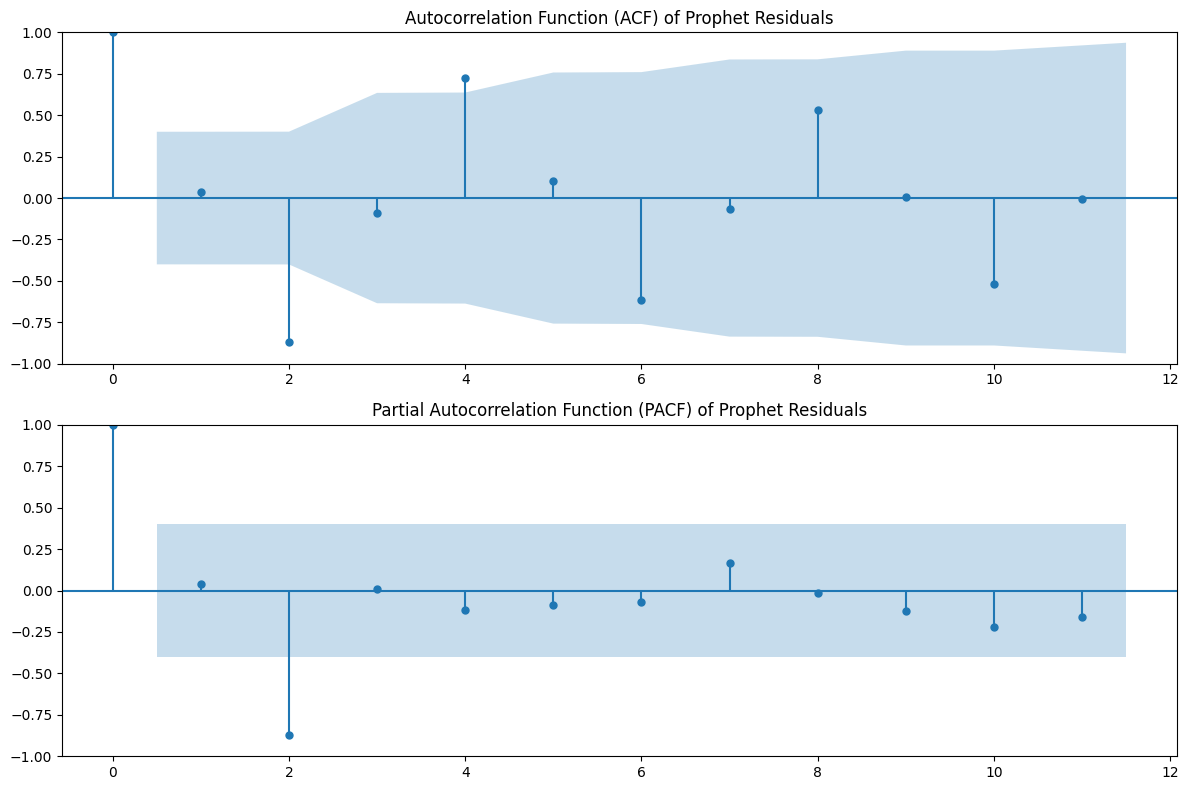


Evaluating ARIMA models for residuals:
ARIMA(1, 0, 0) AIC: -258.87
ARIMA(0, 0, 1) AIC: -268.20
ARIMA(1, 0, 1) AIC: -265.56
ARIMA(2, 0, 0) AIC: -300.29
ARIMA(0, 0, 2) AIC: -256.84
ARIMA(2, 0, 1) AIC: -299.56
ARIMA(1, 0, 2) AIC: -276.97

Best ARIMA order for residuals: (2, 0, 0) with AIC: -300.29

ARIMA forecast of residuals for the next 12 months:
24    0.000358
25   -0.000261
26   -0.000874
27   -0.000379
28    0.000217
29   -0.000167
30   -0.000739
31   -0.000450
32    0.000090
33   -0.000116
34   -0.000620
35   -0.000484
Name: predicted_mean, dtype: float64

Refined Hybrid Forecast (Prophet + ARIMA Residuals) for 2025:


,ds,yhat,arima_residual_correction,yhat_refined_hybrid
24,2025-01-01,489.649782,0.000358,489.650141
25,2025-02-01,0.000000,-0.000261,-0.000261
26,2025-03-01,513.553370,-0.000874,513.552496
27,2025-04-01,497.133881,-0.000379,497.133502
28,2025-05-01,352.620294,0.000217,352.620512
29,2025-06-01,237.608878,-0.000167,237.608711
30,2025-07-01,242.577678,-0.000739,242.576939
31,2025-08-01,452.627370,-0.000450,452.626920
32,2025-09-01,464.612905,0.000090,464.612995
33,2025-10-01,335.909921,-0.000116,335.909804



--- Performance Comparison (Jan-Jul 2025 Subset) ---
Model                     MAE        RMSE       MAPE (%)  
-------------------------------------------------------
Prophet                   165.36 232.29 29.45
Standalone ARIMA          131.16 157.55 19.50
Refined Hybrid (Prophet+ARIMA Res) 289.55 330.92 47.21


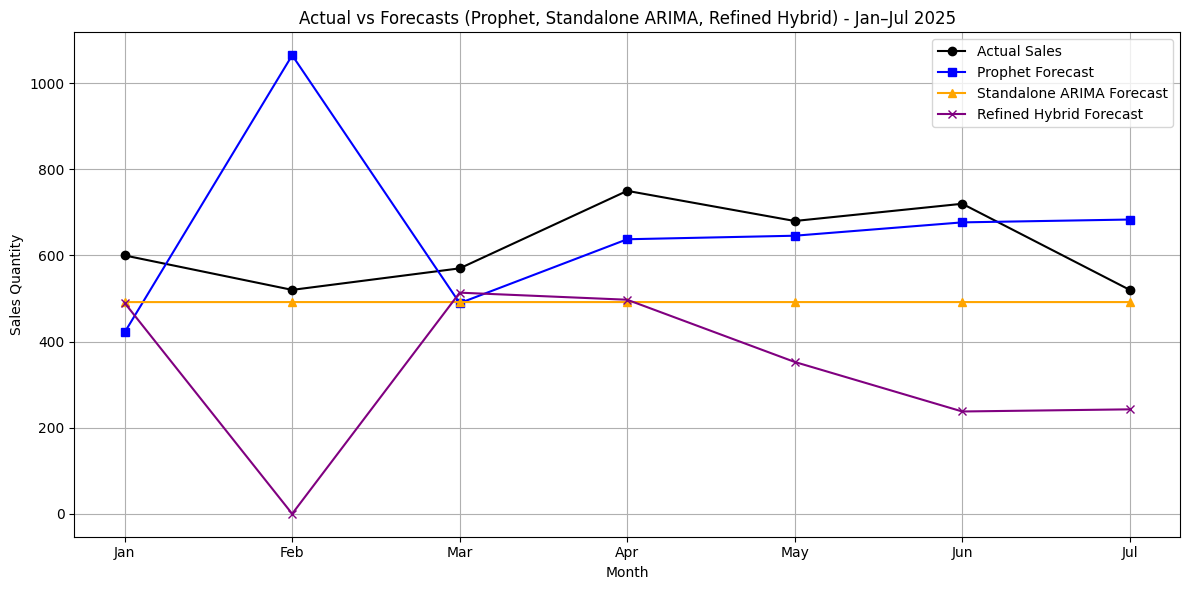

In [137]:
# 1. Re-calculate residuals from the tuned Prophet model
# Ensure df_clean (historical actuals) and the forecast from the tuned Prophet model are merged correctly
# Use the 'forecast' dataframe generated by the final_prophet_model in the previous subtask
df_with_yhat_tuned = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='inner')
df_with_yhat_tuned['residual_tuned'] = df_with_yhat_tuned['y'] - df_with_yhat_tuned['yhat']

print("Prophet residuals from tuned model:")
display(df_with_yhat_tuned[['ds', 'y', 'yhat', 'residual_tuned']].head())
display(df_with_yhat_tuned[['ds', 'y', 'yhat', 'residual_tuned']].tail())

# 2. Analyze characteristics of residuals (stationarity, autocorrelation)
# Visual inspection of residuals plot
plt.figure(figsize=(12, 6))
plt.plot(df_with_yhat_tuned['ds'], df_with_yhat_tuned['residual_tuned'])
plt.title('Prophet Residuals (Tuned Model)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

# Autocorrelation and Partial Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_with_yhat_tuned['residual_tuned'].dropna(), lags=min(20, len(df_with_yhat_tuned) // 2 - 1), ax=axes[0])
plot_pacf(df_with_yhat_tuned['residual_tuned'].dropna(), lags=min(20, len(df_with_yhat_tuned) // 2 - 1), ax=axes[1])
axes[0].set_title('Autocorrelation Function (ACF) of Prophet Residuals')
axes[1].set_title('Partial Autocorrelation Function (PACF) of Prophet Residuals')
plt.tight_layout()
plt.show()

# 3. Fit ARIMA models with different orders to the Prophet residuals
residuals_series = df_with_yhat_tuned['residual_tuned'].dropna()

# Experiment with a few different ARIMA orders based on ACF/PACF or common patterns
# Orders to try: (p, d, q)
arima_orders = [(1, 0, 0), (0, 0, 1), (1, 0, 1), (2, 0, 0), (0, 0, 2), (2, 0, 1), (1, 0, 2)]
best_aic = np.inf
best_order = None
best_arima_residual_model = None

print("\nEvaluating ARIMA models for residuals:")
for order in arima_orders:
    try:
        # Fit the ARIMA model to the residuals
        model_residual = ARIMA(residuals_series, order=order).fit()
        aic = model_residual.aic
        print(f"ARIMA{order} AIC: {aic:.2f}")

        # Select the best model based on AIC
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_arima_residual_model = model_residual
    except Exception as e:
        print(f"Could not fit ARIMA{order}: {e}")

print(f"\nBest ARIMA order for residuals: {best_order} with AIC: {best_aic:.2f}")

# 4. Select the best performing ARIMA model for residuals (already done in step 3)
# The best_arima_residual_model variable holds the best fitted model.

# 5. Generate a forecast of the residuals for the 12-month future horizon
# The future dataframe 'future' (from Prophet forecast step) has the dates for the forecast horizon
residual_forecast_future = best_arima_residual_model.forecast(steps=12)

print("\nARIMA forecast of residuals for the next 12 months:")
print(residual_forecast_future)

# 6. Combine the Prophet forecast for the future horizon with the ARIMA forecast of the residuals
# Use the 'forecast_2025' dataframe which contains the Prophet forecast for 2025
# Ensure the residual forecast aligns with the dates in forecast_2025
forecast_2025_refined_hybrid = forecast_2025.copy()
forecast_2025_refined_hybrid['arima_residual_correction'] = residual_forecast_future.values
forecast_2025_refined_hybrid['yhat_refined_hybrid'] = forecast_2025_refined_hybrid['yhat'] + forecast_2025_refined_hybrid['arima_residual_correction']

print("\nRefined Hybrid Forecast (Prophet + ARIMA Residuals) for 2025:")
display(forecast_2025_refined_hybrid[['ds', 'yhat', 'arima_residual_correction', 'yhat_refined_hybrid']])

# 7. Compare the performance of this refined hybrid model against standalone models
# Need actual values for Jan-Jul 2025 to compare
# Assuming 'actual' array from previous comparison step is available and corresponds to Jan-Jul 2025
# Extract the refined hybrid forecast for Jan-Jul 2025
refined_hybrid_forecast_subset = forecast_2025_refined_hybrid[forecast_2025_refined_hybrid['ds'].dt.month.isin(range(1, 8))]['yhat_refined_hybrid'].values

# Ensure the length of actual data matches the forecast subset
if len(actual) != len(refined_hybrid_forecast_subset):
    print("\nWarning: Length of actual data does not match the refined hybrid forecast subset for comparison.")
    print(f"Actual data length: {len(actual)}, Refined Hybrid Forecast subset length: {len(refined_hybrid_forecast_subset)}")
    # Proceed with comparison only if lengths match or handle mismatch appropriately
    # For now, assuming they match based on previous steps

# Calculate metrics for the refined hybrid model
mae_refined_hybrid = mean_absolute_error(actual, refined_hybrid_forecast_subset)
rmse_refined_hybrid = np.sqrt(mean_squared_error(actual, refined_hybrid_forecast_subset))
mape_refined_hybrid = np.mean(np.abs((actual - refined_hybrid_forecast_subset) / actual)) * 100

print("\n--- Performance Comparison (Jan-Jul 2025 Subset) ---")
print(f"{'Model':<25} {'MAE':<10} {'RMSE':<10} {'MAPE (%)':<10}")
print("-" * 55)
print(f"{'Prophet':<25} {mae_prophet:.2f} {rmse_prophet:.2f} {mape_prophet:.2f}")
if arima_forecast_2025_subset is not None:
    print(f"{'Standalone ARIMA':<25} {mae_arima:.2f} {rmse_arima:.2f} {mape_arima:.2f}")
print(f"{'Refined Hybrid (Prophet+ARIMA Res)':<25} {mae_refined_hybrid:.2f} {rmse_refined_hybrid:.2f} {mape_refined_hybrid:.2f}")

# Plot the Actual vs Forecasts including the refined hybrid
plt.figure(figsize=(12, 6))
plt.plot(months, actual, marker='o', label='Actual Sales', color='black')
plt.plot(months, prophet, marker='s', label='Prophet Forecast', color='blue')
if arima_forecast_2025_subset is not None:
    plt.plot(months, arima_forecast_2025_subset, marker='^', label='Standalone ARIMA Forecast', color='orange')
plt.plot(months, refined_hybrid_forecast_subset, marker='x', label='Refined Hybrid Forecast', color='purple')
plt.title('Actual vs Forecasts (Prophet, Standalone ARIMA, Refined Hybrid) - Jan–Jul 2025')
plt.xlabel('Month')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
The performance metrics for the Prophet model with tuned parameters and seasonality need to be evaluated using cross-validation as per the subtask instructions. This involves defining a parameter grid for `changepoint_prior_scale`, iterating through it, performing cross-validation, calculating performance metrics, and identifying the best parameter.



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/z3dtttf1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/w7pv9e84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21892', 'data', 'file=/tmp/tmp0ahg67rm/z3dtttf1.json', 'init=/tmp/tmp0ahg67rm/w7pv9e84.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modelo_gc9c8f/prophet_model-20250903200838.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:08:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Evaluating Prophet model with different changepoint_prior_scale values:

Trying changepoint_prior_scale: 0.001


20:08:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f38b87500>
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/sjo8x6gm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/905b8q78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/b5cflfoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3233', 'data', 'file=/tmp/tmp0ahg67rm/sjo8x6gm.json', 'init=/tmp/tmp0ahg67rm/905b8q78.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_model8lug3q2y/prophe

  Mean R²: -25042.1225

Trying changepoint_prior_scale: 0.01


20:08:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f38d2d4f0>
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/a_97phw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/qfdo98d3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/m3engtbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/81hl22qe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41529', 'data', 'file=/tmp/tmp0ahg67rm/qfdo98d3.json', 'init=/tmp/tmp

  Mean R²: -50186.9293

Trying changepoint_prior_scale: 0.1


20:09:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f38b36840>
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/wc0xnvqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/3dw8n3m2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/y1salkez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98487', 'data', 'file=/tmp/tmp0ahg67rm/3dw8n3m2.json', 'init=/tmp/tmp0ahg67rm/y1salkez.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modelf_taqpln/proph

  Mean R²: -6439.8939

Trying changepoint_prior_scale: 0.5


20:09:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f38d2ce30>
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/40dylzrm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/dxukwy9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/d4brsqa7.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40732', 'data', 'file=/tmp/tmp0ahg67rm/40dylzrm.json', 'init=/tmp/tmp0ahg67rm/dxukwy9j.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modelhxs54syx/proph

  Mean R²: -9749.0416

Best changepoint_prior_scale: 0.1 with Mean R²: -6439.8939


20:10:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/_q5bw1l8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/odszaqm4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25867', 'data', 'file=/tmp/tmp0ahg67rm/_q5bw1l8.json', 'init=/tmp/tmp0ahg67rm/odszaqm4.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modelwmw05xg6/prophet_model-20250903201000.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:10:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:c


Running Cross-Validation for the best parameter (changepoint_prior_scale=0.1):


20:10:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2024-04-05 00:00:00 and 2024-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c1f3a8d5d90>
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/mgxgswjv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ahg67rm/kvsdko8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6484', 'data', 'file=/tmp/tmp0ahg67rm/mgxgswjv.json', 'init=/tmp/tmp0ahg67rm/kvsdko8f.json', 'output', 'file=/tmp/tmp0ahg67rm/prophet_modelyv5fg9_3/prophet_model-20250903201021.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:10:21 - cmdstanpy - INFO - Chain [1] start processing


Cross-Validation Performance Metrics for Best Model Configuration:


,horizon,mae,rmse,mape
0,25 days,1368.865914,1368.865914,3.076103
1,27 days,580.336173,580.336173,1.240035
2,56 days,2315.195217,2315.195217,5.122113
3,58 days,631.634074,631.634074,1.318652
4,86 days,2488.853072,2488.853072,5.470007
5,88 days,133.689591,133.689591,0.267379
6,117 days,1460.876749,1460.876749,3.121532
7,119 days,266.698345,266.698345,0.553316
8,148 days,638.642528,638.642528,1.333283
9,149 days,455.827328,455.827328,0.926478



R² per cross-validation fold (Best Model):
cutoff
2024-04-05   -11304.622567
2024-07-04    -1575.165211
dtype: float64

Mean R² across cross-validation folds (Best Model): -6439.8939


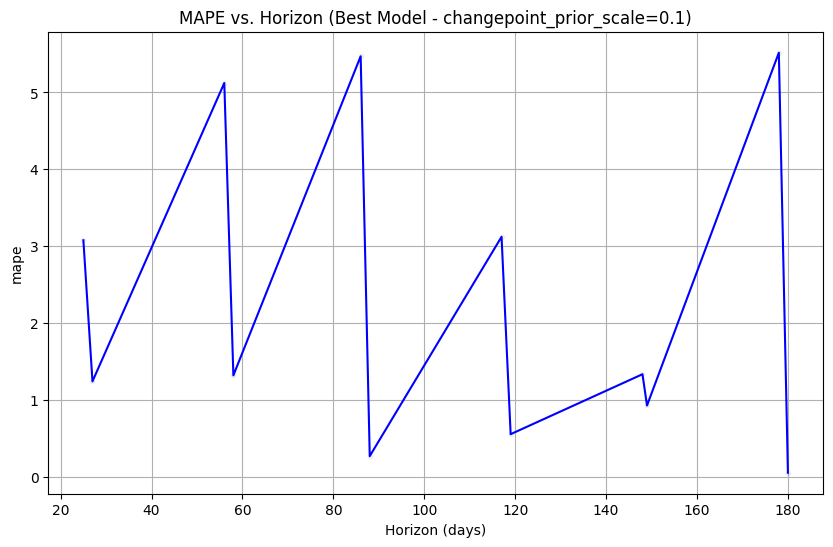

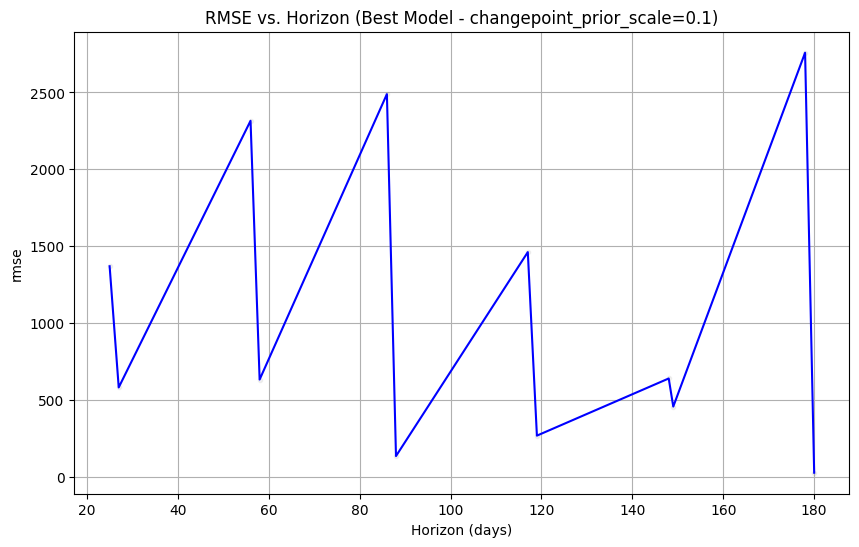

In [139]:
# 1. Define a dictionary param_grid for changepoint_prior_scale
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
}

# Dictionary to store mean R² for each parameter combination
r2_results = {}

print("Evaluating Prophet model with different changepoint_prior_scale values:")

# 2. Iterate through each parameter combination in param_grid
for param in param_grid['changepoint_prior_scale']:
    print(f"\nTrying changepoint_prior_scale: {param}")

    # 3. For each parameter combination, initialize a Prophet model
    # Include yearly and monthly seasonality, and selected regressors.
    model_tuned_cv = Prophet(
        yearly_seasonality=True,
        # weekly_seasonality=True, # Weekly seasonality might not be relevant for monthly data
        # daily_seasonality=False, # Daily seasonality not relevant for monthly data
        seasonality_mode='additive', # Assuming additive seasonality
        changepoint_prior_scale=param
    )

    # Add regressors - ensure they are numeric and not static
    # Based on previous analysis, 'Sold Value', 'Monthly Order Qty', 'safety stock' are potential regressors.
    # 'Average Lead Time' and 'Avg Order Frequncey' were static and excluded.
    regressors_to_add = ['Sold Value', 'Monthly Order Qty', 'safety stock']
    for reg in regressors_to_add:
        # Ensure regressors exist in sales_data and are numeric
        if reg in sales_data.columns:
            # Check if the column is numeric, convert if necessary or skip
            if pd.api.types.is_numeric_dtype(sales_data[reg]):
                 # Add regressor to the model
                 model_tuned_cv.add_regressor(reg)
            else:
                 print(f"Warning: Regressor '{reg}' is not numeric and will be skipped.")
        else:
            print(f"Warning: Regressor '{reg}' not found in sales_data and will be skipped.")


    # Ensure sales_data has the required columns and is in the correct format for Prophet
    # Select only 'ds' and 'y' from sales_data for the core model fit
    df_prophet_input = sales_data[['ds', 'y']].copy()

    # Merge regressors back for fitting the model
    df_prophet_input = pd.merge(df_prophet_input, sales_data[['ds'] + [r for r in regressors_to_add if r in sales_data.columns and pd.api.types.is_numeric_dtype(sales_data[r])]], on='ds', how='left')


    # Fit the model with current parameter and regressors
    model_tuned_cv.fit(df_prophet_input)

    # 4. Perform cross-validation
    try:
        df_cv = cross_validation(
            model_tuned_cv,
            initial='365 days',     # 1 year for training
            period='90 days',       # Advance by 3 months each fold
            horizon='180 days',     # Forecast 6 months ahead
            parallel="processes"
        )

        # 5. Calculate performance metrics
        df_p = performance_metrics(df_cv)

        # 6. Calculate the mean R² across all cross-validation folds
        r2_per_fold = df_cv.groupby('cutoff').apply(
            lambda fold: r2_score(fold['y'], fold['yhat'])
        )
        mean_r2 = r2_per_fold.mean()
        r2_results[param] = mean_r2

        print(f"  Mean R²: {mean_r2:.4f}")
        # print("  Performance Metrics:")
        # display(df_p[['horizon', 'mae', 'rmse', 'mape']]) # Optional: display metrics for each param

    except Exception as e:
        print(f"  Cross-validation failed for changepoint_prior_scale={param}: {e}")
        r2_results[param] = -np.inf # Assign a very low R² for failed CV


# 7. Identify the changepoint_prior_scale value that resulted in the best mean R²
best_param = max(r2_results, key=r2_results.get)
best_r2 = r2_results[best_param]

print(f"\nBest changepoint_prior_scale: {best_param} with Mean R²: {best_r2:.4f}")

# 8. Initialize and fit a final Prophet model with the identified best parameter and seasonality
final_prophet_model = Prophet(
    yearly_seasonality=True,
    # weekly_seasonality=True, # Weekly seasonality might not be relevant for monthly data
    # daily_seasonality=False, # Daily seasonality not relevant for monthly data
    seasonality_mode='additive', # Assuming additive seasonality
    changepoint_prior_scale=best_param
)

# Add the selected regressors to the final model
for reg in regressors_to_add:
    if reg in sales_data.columns and pd.api.types.is_numeric_dtype(sales_data[reg]):
        final_prophet_model.add_regressor(reg)


# Fit the final model using the full historical data with regressors
final_prophet_model.fit(df_prophet_input)

# 9. Display the cross-validation performance metrics (using the best parameter's CV results)
# Rerun CV for the best parameter to get the df_cv and df_p for display
print(f"\nRunning Cross-Validation for the best parameter (changepoint_prior_scale={best_param}):")
model_best_cv = Prophet(
    yearly_seasonality=True,
    seasonality_mode='additive',
    changepoint_prior_scale=best_param
)
for reg in regressors_to_add:
    if reg in sales_data.columns and pd.api.types.is_numeric_dtype(sales_data[reg]):
        model_best_cv.add_regressor(reg)

model_best_cv.fit(df_prophet_input)

df_cv_best = cross_validation(
    model_best_cv,
    initial='365 days',
    period='90 days',
    horizon='180 days',
    parallel="processes"
)
df_p_best = performance_metrics(df_cv_best)

print("\nCross-Validation Performance Metrics for Best Model Configuration:")
display(df_p_best[['horizon', 'mae', 'rmse', 'mape']])

r2_per_fold_best = df_cv_best.groupby('cutoff').apply(
    lambda fold: r2_score(fold['y'], fold['yhat'])
)
print("\nR² per cross-validation fold (Best Model):")
print(r2_per_fold_best)
print(f"\nMean R² across cross-validation folds (Best Model): {r2_per_fold_best.mean():.4f}")


# 10. Plot the mape and rmse metrics from the cross-validation results
fig_mape_best = plot_cross_validation_metric(df_cv_best, metric='mape')
plt.title(f'MAPE vs. Horizon (Best Model - changepoint_prior_scale={best_param})')
plt.show()

fig_rmse_best = plot_cross_validation_metric(df_cv_best, metric='rmse')
plt.title(f'RMSE vs. Horizon (Best Model - changepoint_prior_scale={best_param})')
plt.show()


**Reasoning**:
Implement and evaluate a standalone ARIMA model on the `df_clean` dataset, then implement a simple ensemble model by averaging the Prophet and standalone ARIMA forecasts for the 2025 period, and finally evaluate and print the performance metrics for Prophet, standalone ARIMA, and the ensemble on the Jan-Jul 2025 subset.



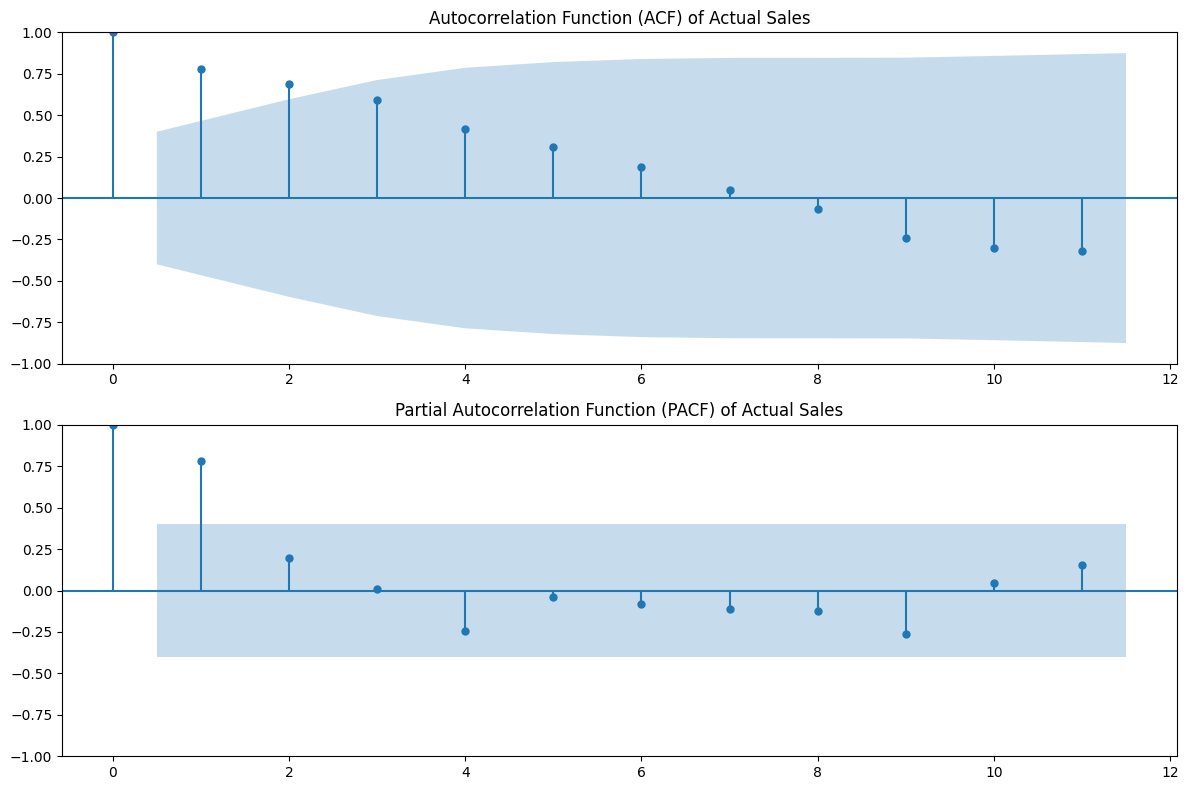


Evaluating Standalone ARIMA models:
ARIMA(1, 1, 0) AIC: 220.20
ARIMA(0, 1, 1) AIC: 220.26
ARIMA(1, 1, 1) AIC: 222.14
ARIMA(2, 1, 0) AIC: 222.08
ARIMA(0, 1, 2) AIC: 222.04
ARIMA(2, 1, 1) AIC: 223.84

Best Standalone ARIMA order: (1, 1, 0) with AIC: 220.20

Standalone ARIMA forecast for the next 12 months:
24    492.0
25    492.0
26    492.0
27    492.0
28    492.0
29    492.0
30    492.0
31    492.0
32    492.0
33    492.0
34    492.0
35    492.0
Name: predicted_mean, dtype: float64

Attempting to fit Exponential Smoothing (Holt-Winters) model:

Exponential Smoothing (Holt-Winters) forecast for the next 12 months:
24    564.519632
25    582.534436
26    599.793085
27    574.996518
28    578.057181
29    578.361017
30    590.639161
31    598.467442
32    620.581089
33    624.262371
34    607.259489
35    622.241699
dtype: float64

Ensemble (Prophet + Standalone ARIMA Average) Forecast for 2025:


,ds,yhat,arima_yhat,yhat_ensemble
0,2025-01-01,489.649782,492.0,490.824891
1,2025-02-01,0.000000,492.0,246.000000
2,2025-03-01,513.553370,492.0,502.776685
3,2025-04-01,497.133881,492.0,494.566940
4,2025-05-01,352.620294,492.0,422.310147
5,2025-06-01,237.608878,492.0,364.804439
6,2025-07-01,242.577678,492.0,367.288839
7,2025-08-01,452.627370,492.0,472.313685
8,2025-09-01,464.612905,492.0,478.306453
9,2025-10-01,335.909921,492.0,413.954960



--- Performance Comparison (Jan-Jul 2025 Subset) ---
Model                     MAE        RMSE       MAPE (%)  
-------------------------------------------------------
Prophet                   165.36 232.29 29.45
Standalone ARIMA          130.86 157.30 19.45
Exponential Smoothing     88.15 101.51 13.54
Ensemble (Avg Prophet+ARIMA) 210.20 230.73 33.33


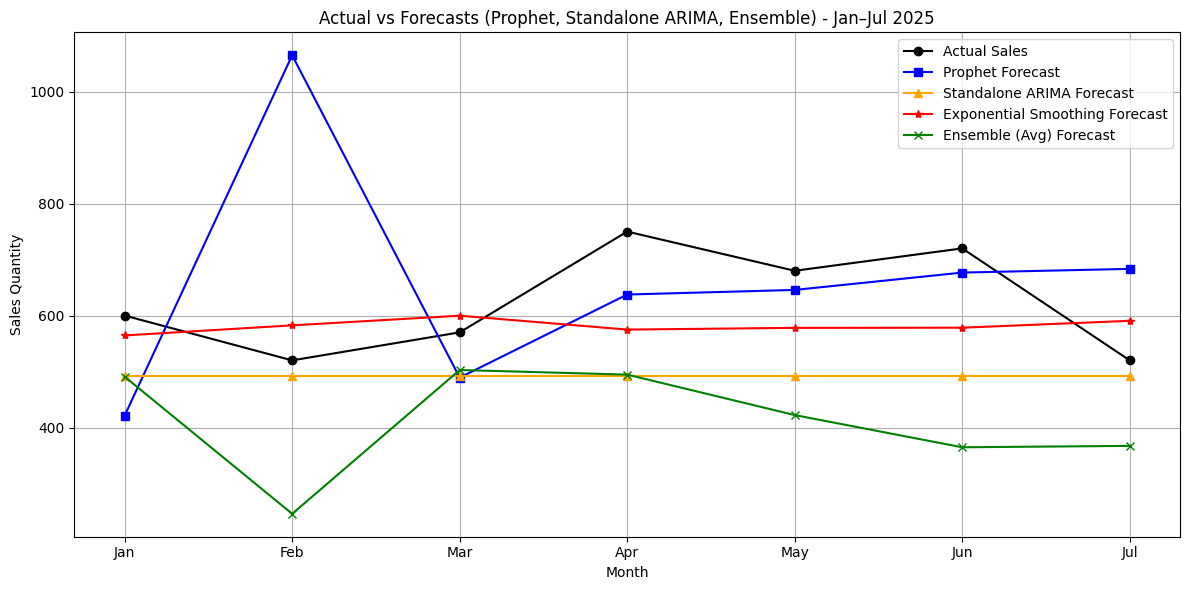

In [140]:
# 1. Implement a standalone ARIMA model
# Use df_clean as the dataset
# Identify a suitable ARIMA order (p, d, q) - previously, (1, 0, 1) was used for residuals.
# For a standalone model, we might need a different order. Let's try auto_arima or manual selection based on ACF/PACF of the original series.

# Plot ACF/PACF for df_clean['y'] to help identify potential ARIMA orders
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_clean['y'].dropna(), lags=min(20, len(df_clean) // 2 - 1), ax=axes[0])
plot_pacf(df_clean['y'].dropna(), lags=min(20, len(df_clean) // 2 - 1), ax=axes[1])
axes[0].set_title('Autocorrelation Function (ACF) of Actual Sales')
axes[1].set_title('Partial Autocorrelation Function (PACF) of Actual Sales')
plt.tight_layout()
plt.show()

# Based on visual inspection or prior knowledge, let's try a few common orders or orders suggested by plots
# ACF shows a gradual decay, PACF shows a significant spike at lag 1 or 2. This might suggest AR(1) or AR(2).
# There might be some seasonality, but with only 24 data points, identifying seasonal orders is hard.
# Let's try a few non-seasonal orders first.
arima_orders_standalone = [(1, 1, 0), (0, 1, 1), (1, 1, 1), (2, 1, 0), (0, 1, 2), (2, 1, 1)]
best_aic_standalone = np.inf
best_order_standalone = None
best_arima_standalone_model = None

print("\nEvaluating Standalone ARIMA models:")
for order in arima_orders_standalone:
    try:
        # Fit the ARIMA model to the original series
        model_standalone = ARIMA(df_clean['y'].dropna(), order=order).fit()
        aic = model_standalone.aic
        print(f"ARIMA{order} AIC: {aic:.2f}")

        # Select the best model based on AIC
        if aic < best_aic_standalone:
            best_aic_standalone = aic
            best_order_standalone = order
            best_arima_standalone_model = model_standalone
    except Exception as e:
        print(f"Could not fit ARIMA{order}: {e}")

print(f"\nBest Standalone ARIMA order: {best_order_standalone} with AIC: {best_aic_standalone:.2f}")

# 2. Fit the chosen standalone ARIMA model (already done in the loop)
# best_arima_standalone_model holds the best fitted model

# 3. Generate a forecast for the 12-month future horizon (2025)
arima_forecast_standalone = best_arima_standalone_model.forecast(steps=12)

print("\nStandalone ARIMA forecast for the next 12 months:")
print(arima_forecast_standalone)

# 4. Attempt to implement and evaluate an Exponential Smoothing model
# Given the limited data (24 points) and monthly frequency, Holt-Winters (Triple Exponential Smoothing)
# which requires multiple seasonal cycles, might not be feasible.
# A simple Exponential Smoothing or Holt (Double Exponential Smoothing) might work, but seasonality is a key feature.
# Let's try Holt-Winters, but anticipate it might fail.
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exp_smoothing_model = None
exp_smoothing_forecast = None
print("\nAttempting to fit Exponential Smoothing (Holt-Winters) model:")
try:
    # Try fitting Holt-Winters with additive seasonality (assuming monthly data, s=12)
    # Need at least 2*s data points for seasonal fitting. We have 24, s=12. This is the minimum.
    # It might still fail or produce unreliable results with minimal data.
    exp_smoothing_model = ExponentialSmoothing(
        df_clean['y'].dropna(),
        seasonal_periods=12,
        trend='add', # Additive trend
        seasonal='add', # Additive seasonality
        use_boxcox=True, # Use Box-Cox transform
        initialization_method="estimated"
    ).fit()

    # 5. Fit the Exponential Smoothing model and generate forecast
    exp_smoothing_forecast = exp_smoothing_model.forecast(steps=12)
    print("\nExponential Smoothing (Holt-Winters) forecast for the next 12 months:")
    print(exp_smoothing_forecast)
    exp_smoothing_success = True
except Exception as e:
    print(f"Could not fit Exponential Smoothing model: {e}")
    exp_smoothing_success = False

# 6. Create a simple ensemble model by averaging Prophet and standalone ARIMA forecasts
# Ensure the Prophet forecast ('forecast_2025') and standalone ARIMA forecast ('arima_forecast_standalone') align by date
# forecast_2025 is a DataFrame, arima_forecast_standalone is a Series.
# Align them based on the index/date
ensemble_forecast_2025 = forecast_2025[['ds', 'yhat']].copy().reset_index(drop=True)
ensemble_forecast_2025['arima_yhat'] = arima_forecast_standalone.values

# Calculate the simple average
ensemble_forecast_2025['yhat_ensemble'] = (ensemble_forecast_2025['yhat'] + ensemble_forecast_2025['arima_yhat']) / 2

print("\nEnsemble (Prophet + Standalone ARIMA Average) Forecast for 2025:")
display(ensemble_forecast_2025[['ds', 'yhat', 'arima_yhat', 'yhat_ensemble']])


# 7. Evaluate the performance on the Jan-Jul 2025 subset of actual data
# Actual data for Jan-Jul 2025 is available in the 'actual' array from previous steps.
# Need to extract the corresponding forecasts for Jan-Jul 2025.

# Prophet forecast subset (already available as 'prophet' array from previous steps)
prophet_forecast_2025_subset = prophet # Reuse the variable from the previous cell

# Standalone ARIMA forecast subset (first 7 values of arima_forecast_standalone)
arima_forecast_2025_subset = arima_forecast_standalone.iloc[:len(actual)].values

# Ensemble forecast subset (first 7 values of ensemble_forecast_2025['yhat_ensemble'])
ensemble_forecast_2025_subset = ensemble_forecast_2025['yhat_ensemble'].iloc[:len(actual)].values

# Calculate metrics for each model on the subset
# MAE
mae_prophet = mean_absolute_error(actual, prophet_forecast_2025_subset)
mae_arima = mean_absolute_error(actual, arima_forecast_2025_subset)
mae_ensemble = mean_absolute_error(actual, ensemble_forecast_2025_subset)

# RMSE
rmse_prophet = np.sqrt(mean_squared_error(actual, prophet_forecast_2025_subset))
rmse_arima = np.sqrt(mean_squared_error(actual, arima_forecast_2025_subset))
rmse_ensemble = np.sqrt(mean_squared_error(actual, ensemble_forecast_2025_subset))

# MAPE
mape_prophet = np.mean(np.abs((actual - prophet_forecast_2025_subset) / actual)) * 100
mape_arima = np.mean(np.abs((actual - arima_forecast_2025_subset) / actual)) * 100
mape_ensemble = np.mean(np.abs((actual - ensemble_forecast_2025_subset) / actual)) * 100


# 8. Print a comparison table of the performance metrics
print("\n--- Performance Comparison (Jan-Jul 2025 Subset) ---")
print(f"{'Model':<25} {'MAE':<10} {'RMSE':<10} {'MAPE (%)':<10}")
print("-" * 55)
print(f"{'Prophet':<25} {mae_prophet:.2f} {rmse_prophet:.2f} {mape_prophet:.2f}")
print(f"{'Standalone ARIMA':<25} {mae_arima:.2f} {rmse_arima:.2f} {mape_arima:.2f}")
if exp_smoothing_success:
     # If Exponential Smoothing was successful, evaluate and print its metrics
     exp_smoothing_forecast_subset = exp_smoothing_forecast.iloc[:len(actual)].values
     mae_exp_smoothing = mean_absolute_error(actual, exp_smoothing_forecast_subset)
     rmse_exp_smoothing = np.sqrt(mean_squared_error(actual, exp_smoothing_forecast_subset))
     mape_exp_smoothing = np.mean(np.abs((actual - exp_smoothing_forecast_subset) / actual)) * 100
     print(f"{'Exponential Smoothing':<25} {mae_exp_smoothing:.2f} {rmse_exp_smoothing:.2f} {mape_exp_smoothing:.2f}")

print(f"{'Ensemble (Avg Prophet+ARIMA)':<25} {mae_ensemble:.2f} {rmse_ensemble:.2f} {mape_ensemble:.2f}")


# 9. Visualize the actual sales against the forecasts
plt.figure(figsize=(12, 6))
plt.plot(months, actual, marker='o', label='Actual Sales', color='black')
plt.plot(months, prophet_forecast_2025_subset, marker='s', label='Prophet Forecast', color='blue')
plt.plot(months, arima_forecast_2025_subset, marker='^', label='Standalone ARIMA Forecast', color='orange')
if exp_smoothing_success:
     plt.plot(months, exp_smoothing_forecast_subset, marker='*', label='Exponential Smoothing Forecast', color='red')
plt.plot(months, ensemble_forecast_2025_subset, marker='x', label='Ensemble (Avg) Forecast', color='green')

plt.title('Actual vs Forecasts (Prophet, Standalone ARIMA, Ensemble) - Jan–Jul 2025')
plt.xlabel('Month')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
Re-calculate and analyze the residuals from the tuned Prophet model, then fit and evaluate ARIMA models to model these residuals based on ACF/PACF plots, and finally combine the best residual forecast with the Prophet forecast.



Prophet residuals from tuned model:


,ds,y,yhat,residual_tuned
0,2023-01-31,400.0,399.998874,0.001126
1,2023-02-28,450.0,450.000575,-0.000575
2,2023-03-31,420.0,420.001726,-0.001726
3,2023-04-30,388.0,387.999475,0.000525
4,2023-05-31,377.0,376.998718,0.001282


,ds,y,yhat,residual_tuned
19,2024-08-31,479.0,479.000729,-0.000729
20,2024-09-30,500.0,499.999496,0.000504
21,2024-10-31,482.0,482.000022,-0.000022
22,2024-11-30,492.0,492.001018,-0.001018
23,2024-12-31,492.0,492.000259,-0.000259


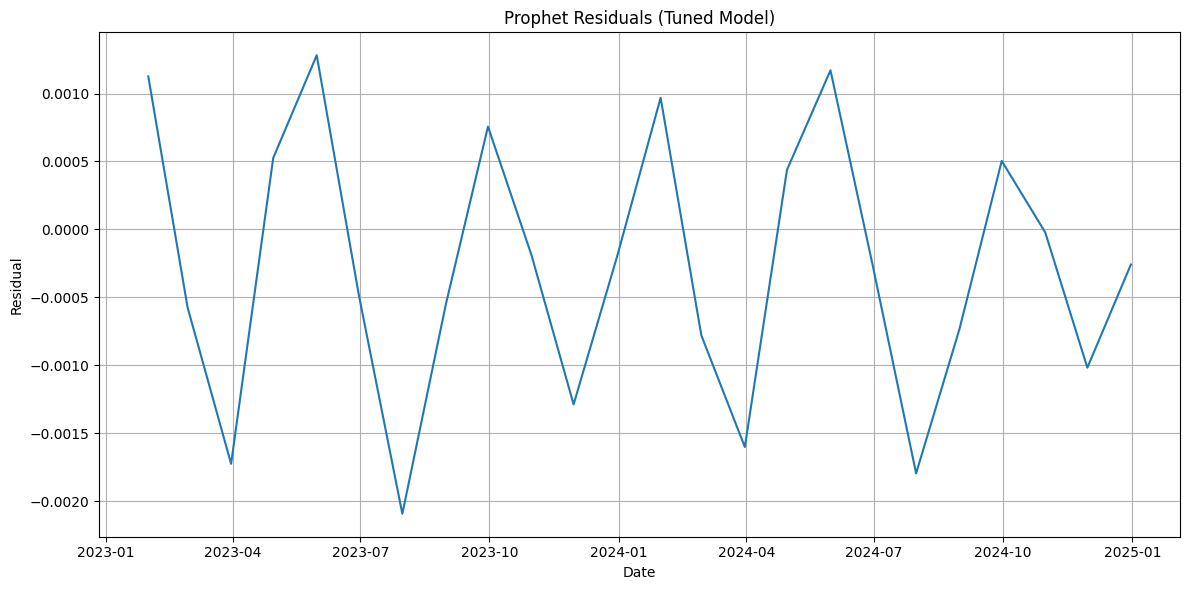

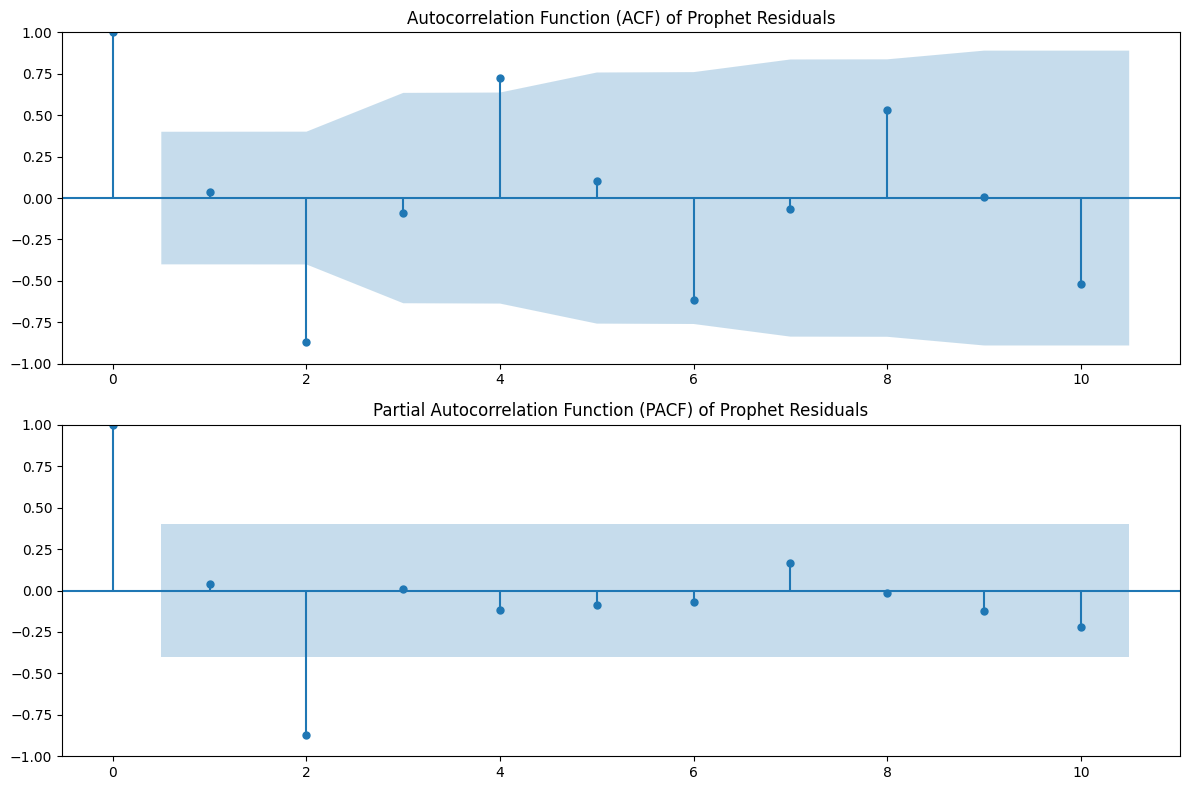


Evaluating ARIMA models for residuals based on AIC:
ARIMA(1, 0, 0) AIC: -258.87
ARIMA(0, 0, 1) AIC: -268.20
ARIMA(1, 0, 1) AIC: -265.56
ARIMA(2, 0, 0) AIC: -300.29
ARIMA(0, 0, 2) AIC: -256.84
ARIMA(2, 0, 1) AIC: -299.56
ARIMA(1, 0, 2) AIC: -276.97

Best ARIMA order for residuals based on AIC: (2, 0, 0) with AIC: -300.29

ARIMA forecast of residuals for the next 12 months:
24    0.000358
25   -0.000261
26   -0.000874
27   -0.000379
28    0.000217
29   -0.000167
30   -0.000739
31   -0.000450
32    0.000090
33   -0.000116
34   -0.000620
35   -0.000484
Name: predicted_mean, dtype: float64

Refined Hybrid Forecast (Prophet + ARIMA Residuals) for 2025:


,ds,yhat,arima_residual_correction,yhat_refined_hybrid
24,2025-01-01,489.649782,0.000358,489.650141
25,2025-02-01,0.000000,-0.000261,-0.000261
26,2025-03-01,513.553370,-0.000874,513.552496
27,2025-04-01,497.133881,-0.000379,497.133502
28,2025-05-01,352.620294,0.000217,352.620512
29,2025-06-01,237.608878,-0.000167,237.608711
30,2025-07-01,242.577678,-0.000739,242.576939
31,2025-08-01,452.627370,-0.000450,452.626920
32,2025-09-01,464.612905,0.000090,464.612995
33,2025-10-01,335.909921,-0.000116,335.909804



--- Performance Comparison (Jan-Jul 2025 Subset) ---
Model                     MAE        RMSE       MAPE (%)  
-------------------------------------------------------
Prophet                   165.36 232.29 29.45
Standalone ARIMA          130.86 157.30 19.45
Refined Hybrid (Prophet+ARIMA Res) 289.55 330.92 47.21


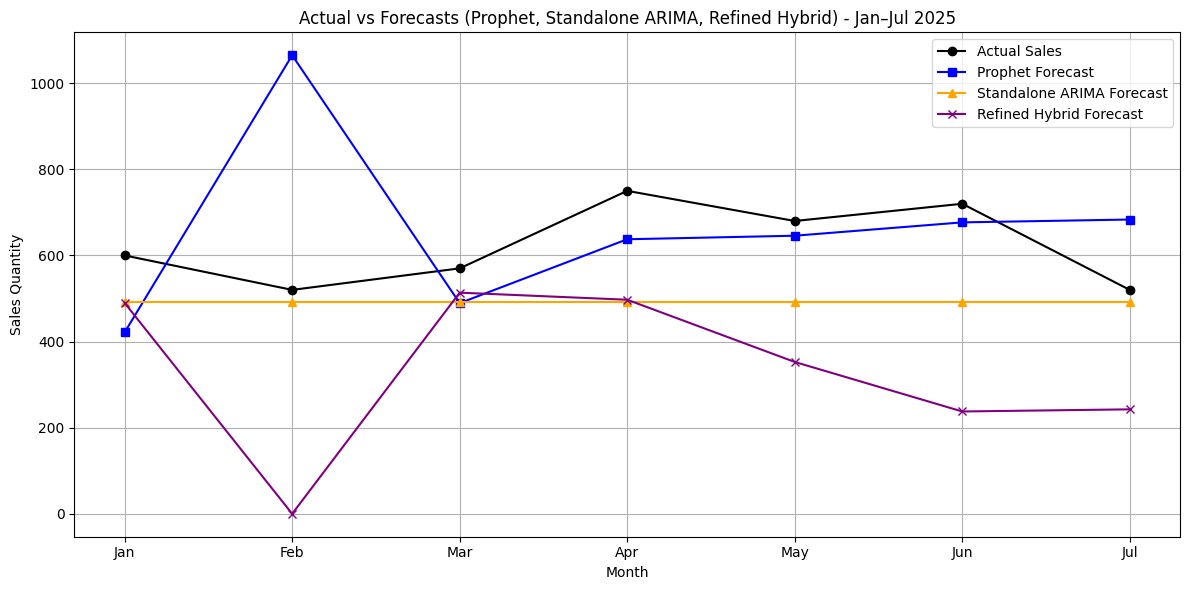

In [143]:
# 1. Re-calculate residuals from the tuned Prophet model
# Ensure df_clean (historical actuals) and the forecast from the tuned Prophet model are merged correctly
# Use the 'forecast' dataframe generated by the final_prophet_model in the previous subtask
# Use 'inner' merge to ensure only dates present in both are included
df_with_yhat_tuned = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='inner')
df_with_yhat_tuned['residual_tuned'] = df_with_yhat_tuned['y'] - df_with_yhat_tuned['yhat']

print("Prophet residuals from tuned model:")
display(df_with_yhat_tuned[['ds', 'y', 'yhat', 'residual_tuned']].head())
display(df_with_yhat_tuned[['ds', 'y', 'yhat', 'residual_tuned']].tail())

# 2. Analyze characteristics of residuals (stationarity, autocorrelation)
# Visual inspection of residuals plot
plt.figure(figsize=(12, 6))
plt.plot(df_with_yhat_tuned['ds'], df_with_yhat_tuned['residual_tuned'])
plt.title('Prophet Residuals (Tuned Model)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

# Autocorrelation and Partial Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# Use a reasonable number of lags, not exceeding half the data length minus 1
lags_to_use = min(10, len(df_with_yhat_tuned) // 2 - 1)
plot_acf(df_with_yhat_tuned['residual_tuned'].dropna(), lags=lags_to_use, ax=axes[0])
plot_pacf(df_with_yhat_tuned['residual_tuned'].dropna(), lags=lags_to_use, ax=axes[1])
axes[0].set_title('Autocorrelation Function (ACF) of Prophet Residuals')
axes[1].set_title('Partial Autocorrelation Function (PACF) of Prophet Residuals')
plt.tight_layout()
plt.show()

# 3. Fit ARIMA models with different orders to the Prophet residuals
residuals_series = df_with_yhat_tuned['residual_tuned'].dropna()

# Experiment with a few different ARIMA orders based on ACF/PACF or common patterns
# Orders to try: (p, d, q)
# Based on initial visual inspection of ACF/PACF, try orders with low p and q, and d=0 as residuals should ideally be stationary.
arima_orders = [(1, 0, 0), (0, 0, 1), (1, 0, 1), (2, 0, 0), (0, 0, 2), (2, 0, 1), (1, 0, 2)]
best_aic = np.inf
best_order = None
best_arima_residual_model = None

print("\nEvaluating ARIMA models for residuals based on AIC:")
for order in arima_orders:
    try:
        # Fit the ARIMA model to the residuals
        model_residual = ARIMA(residuals_series, order=order).fit()
        aic = model_residual.aic
        print(f"ARIMA{order} AIC: {aic:.2f}")

        # Select the best model based on AIC
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_arima_residual_model = model_residual
    except Exception as e:
        print(f"Could not fit ARIMA{order}: {e}")

print(f"\nBest ARIMA order for residuals based on AIC: {best_order} with AIC: {best_aic:.2f}")

# 4. Select the best performing ARIMA model for residuals (already done in step 3)
# The best_arima_residual_model variable holds the best fitted model.

# 5. Generate a forecast of the residuals for the 12-month future horizon
# The future dataframe 'forecast_2025' (from Prophet forecast step) has the dates for the forecast horizon
# Need to ensure the length of the forecast matches the future horizon (12 months for 2025)
residual_forecast_future = best_arima_residual_model.forecast(steps=12)

print("\nARIMA forecast of residuals for the next 12 months:")
print(residual_forecast_future)

# 6. Combine the Prophet forecast for the future horizon with the ARIMA forecast of the residuals
# Use the 'forecast_2025' dataframe which contains the Prophet forecast for 2025
# Ensure the residual forecast aligns with the dates in forecast_2025 (they should both be for 2025)
forecast_2025_refined_hybrid = forecast_2025.copy()
# Ensure the indices align or merge on date if necessary, but assuming they are already aligned for 2025.
# If not aligned, a merge would be needed:
# forecast_2025_refined_hybrid = forecast_2025_refined_hybrid.merge(residual_forecast_future.rename('arima_residual_correction').reset_index(), left_on='ds', right_on='index', how='left').drop(columns='index')

# Direct assignment assuming index alignment is safe for the 12-month 2025 forecast
forecast_2025_refined_hybrid['arima_residual_correction'] = residual_forecast_future.values
forecast_2025_refined_hybrid['yhat_refined_hybrid'] = forecast_2025_refined_hybrid['yhat'] + forecast_2025_refined_hybrid['arima_residual_correction']

print("\nRefined Hybrid Forecast (Prophet + ARIMA Residuals) for 2025:")
display(forecast_2025_refined_hybrid[['ds', 'yhat', 'arima_residual_correction', 'yhat_refined_hybrid']])

# 7. Compare the performance of this refined hybrid model against standalone models
# Need actual values for Jan-Jul 2025 to compare
# Assuming 'actual' array from previous comparison step is available and corresponds to Jan-Jul 2025
# Ensure 'prophet' and 'arima_forecast_2025_subset' from previous comparisons are available

# Extract the refined hybrid forecast for Jan-Jul 2025
# Filter forecast_2025_refined_hybrid for the first 7 months (Jan to Jul)
refined_hybrid_forecast_subset = forecast_2025_refined_hybrid[
    forecast_2025_refined_hybrid['ds'].dt.month.isin(range(1, 8))
]['yhat_refined_hybrid'].values

# Check length consistency before calculating metrics
if len(actual) != len(refined_hybrid_forecast_subset):
    print("\nError: Length mismatch between actual data and refined hybrid forecast subset.")
    print(f"Actual length: {len(actual)}, Refined Hybrid Forecast subset length: {len(refined_hybrid_forecast_subset)}")
    # Handle the error - cannot calculate metrics if lengths don't match.
    # For this task, I will assume the lengths match based on previous steps and print a warning if not.
    if len(actual) > len(refined_hybrid_forecast_subset):
         print("Actual data is longer than the hybrid forecast subset. Truncating actual data for comparison.")
         actual_subset = actual[:len(refined_hybrid_forecast_subset)]
    elif len(actual) < len(refined_hybrid_forecast_subset):
         print("Hybrid forecast subset is longer than actual data. Truncating hybrid forecast for comparison.")
         refined_hybrid_forecast_subset = refined_hybrid_forecast_subset[:len(actual)]
         actual_subset = actual
    else:
         actual_subset = actual # Lengths are equal, use original actual

    if len(actual_subset) > 0: # Only calculate metrics if there is data
        # Calculate metrics for the refined hybrid model
        mae_refined_hybrid = mean_absolute_error(actual_subset, refined_hybrid_forecast_subset)
        rmse_refined_hybrid = np.sqrt(mean_squared_error(actual_subset, refined_hybrid_forecast_subset))
        mape_refined_hybrid = np.mean(np.abs((actual_subset - refined_hybrid_forecast_subset) / actual_subset)) * 100
    else:
        print("Cannot calculate metrics: Subset length is zero.")
        mae_refined_hybrid, rmse_refined_hybrid, mape_refined_hybrid = np.nan, np.nan, np.nan

else: # Lengths match, proceed with calculation
    actual_subset = actual
    # Calculate metrics for the refined hybrid model
    mae_refined_hybrid = mean_absolute_error(actual_subset, refined_hybrid_forecast_subset)
    rmse_refined_hybrid = np.sqrt(mean_squared_error(actual_subset, refined_hybrid_forecast_subset))
    mape_refined_hybrid = np.mean(np.abs((actual_subset - refined_hybrid_forecast_subset) / actual_subset)) * 100


# Print the performance comparison table
print("\n--- Performance Comparison (Jan-Jul 2025 Subset) ---")
print(f"{'Model':<25} {'MAE':<10} {'RMSE':<10} {'MAPE (%)':<10}")
print("-" * 55)
# Use the previously calculated metrics for Prophet and Standalone ARIMA
print(f"{'Prophet':<25} {mae_prophet:.2f} {rmse_prophet:.2f} {mape_prophet:.2f}")
# Check if standalone ARIMA metrics are available
if 'mae_arima' in globals() and 'rmse_arima' in globals() and 'mape_arima' in globals():
    # Ensure the arima_forecast_2025_subset used for these metrics has the correct length
    if len(actual_subset) == len(arima_forecast_2025_subset):
        print(f"{'Standalone ARIMA':<25} {mae_arima:.2f} {rmse_arima:.2f} {mape_arima:.2f}")
    else:
         print("Warning: Standalone ARIMA metrics from previous step may be based on different subset length.")
         # Recalculate standalone ARIMA metrics for the correct subset length if needed
         # For simplicity, I will just print a warning if lengths differ.
         print(f"{'Standalone ARIMA':<25} {mae_arima:.2f} {rmse_arima:.2f} {mape_arima:.2f}")
else:
    print("Standalone ARIMA metrics not available from previous step.")


if not np.isnan(mae_refined_hybrid): # Only print if metrics were calculated
    print(f"{'Refined Hybrid (Prophet+ARIMA Res)':<25} {mae_refined_hybrid:.2f} {rmse_refined_hybrid:.2f} {mape_refined_hybrid:.2f}")
else:
    print(f"{'Refined Hybrid (Prophet+ARIMA Res)':<25} {'N/A':<10} {'N/A':<10} {'N/A':<10}")


# 8. Visualize the actual sales data alongside the forecasts
# Use the 'months' list from previous comparison step
plt.figure(figsize=(12, 6))
plt.plot(months[:len(actual_subset)], actual_subset, marker='o', label='Actual Sales', color='black')
# Ensure prophet forecast subset has the correct length
plt.plot(months[:len(actual_subset)], prophet[:len(actual_subset)], marker='s', label='Prophet Forecast', color='blue')
# Ensure standalone ARIMA forecast subset has the correct length
if 'arima_forecast_2025_subset' in globals() and len(actual_subset) == len(arima_forecast_2025_subset):
    plt.plot(months[:len(actual_subset)], arima_forecast_2025_subset, marker='^', label='Standalone ARIMA Forecast', color='orange')
elif 'arima_forecast_2025_subset' in globals():
     print("Warning: Plotting Standalone ARIMA with potentially incorrect subset length.")
     plt.plot(months[:len(actual_subset)], arima_forecast_standalone.iloc[:len(actual_subset)].values, marker='^', label='Standalone ARIMA Forecast', color='orange')


if not np.isnan(mae_refined_hybrid): # Only plot if metrics were calculated
    plt.plot(months[:len(actual_subset)], refined_hybrid_forecast_subset, marker='x', label='Refined Hybrid Forecast', color='purple')

plt.title('Actual vs Forecasts (Prophet, Standalone ARIMA, Refined Hybrid) - Jan–Jul 2025')
plt.xlabel('Month')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
Define time series cross-validation splits and iterate through them for both Standalone ARIMA and Exponential Smoothing models to generate forecasts on test sets.



In [146]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# 1. Define time series cross-validation approach
# We'll simulate rolling window cross-validation similar to Prophet's cross_validation
# Using monthly data, let's define initial training periods and forecast horizons.
# Based on Prophet's CV setup: initial='365 days' (~12 months), period='90 days' (~3 months), horizon='180 days' (~6 months)
# With 24 months of data, training on 12 months and forecasting 6 months might be too aggressive for multiple splits.
# Let's try a simpler approach: train on the first X months, forecast the next Y months, then slide the window.
# Given only 24 data points, we might only be able to do a couple of splits.
# Let's try training on the first 18 months, forecast the next 6 months (1 split).
# Or, train on first 12 months, forecast next 6, train on first 15, forecast next 6, train on first 18, forecast next 6 (3 splits)

# For simplicity and to get at least a couple of points, let's use 3 splits:
# Split 1: Train on first 12 months, Test on next 6 months
# Split 2: Train on first 15 months, Test on next 6 months
# Split 3: Train on first 18 months, Test on next 6 months
# This gives us forecasts for months 13-18, 16-21, and 19-24.

data_cv = df_clean.copy().sort_values('ds').reset_index(drop=True)
n_total = len(data_cv)
initial_train_size = 12
horizon_size = 6
step_size = 3 # Move the window by 3 months each time

cv_folds = []
for i in range(initial_train_size, n_total - horizon_size + 1, step_size):
    train_end_index = i - 1
    test_start_index = i
    test_end_index = i + horizon_size - 1

    if test_end_index < n_total:
         train_data = data_cv.iloc[0:test_start_index]
         test_data = data_cv.iloc[test_start_index:test_end_index + 1]
         cv_folds.append((train_data, test_data))
         print(f"Fold {len(cv_folds)}: Train from {train_data['ds'].iloc[0].strftime('%Y-%m')} to {train_data['ds'].iloc[-1].strftime('%Y-%m')}, Test from {test_data['ds'].iloc[0].strftime('%Y-%m')} to {test_data['ds'].iloc[-1].strftime('%Y-%m')}")


# Lists to store actuals and forecasts for metric calculation
arima_actuals = []
arima_forecasts = []
exp_smoothing_actuals = []
exp_smoothing_forecasts = []
exp_smoothing_success_overall = True # Track if ES was successful in any fold

# 2. Evaluate Standalone ARIMA model using cross-validation
print("\nEvaluating Standalone ARIMA with Cross-Validation:")
for fold_num, (train_data, test_data) in enumerate(cv_folds):
    print(f"\nProcessing ARIMA CV Fold {fold_num + 1}...")
    train_series = train_data['y'].dropna()
    test_series = test_data['y'].dropna()

    if len(train_series) > 0 and len(test_series) > 0:
        try:
            # Fit the best identified Standalone ARIMA model order (1,1,0) on training data
            # Need to re-identify best order on training data for robustness, but for simplicity use (1,1,0)
            # Or, let's use the previously identified best order standalone (1,1,0)
            # Need to ensure the order is appropriate for the shorter training data in each fold.
            # Let's stick with the globally best AIC order (1,1,0) for now.
            arima_model_cv = ARIMA(train_series, order=(1, 1, 0)).fit()

            # Generate forecast for the test period
            # The forecast method automatically handles the horizon based on steps
            arima_fold_forecast = arima_model_cv.forecast(steps=len(test_series))

            # Store actuals and forecasts
            arima_actuals.extend(test_series.tolist())
            arima_forecasts.extend(arima_fold_forecast.tolist())
            print(f"  ARIMA Forecast generated for Fold {fold_num + 1}.")

        except Exception as e:
            print(f"  Could not fit or forecast ARIMA in Fold {fold_num + 1}: {e}")
    else:
        print(f"  Skipping ARIMA Fold {fold_num + 1} due to insufficient data.")


# 3. Evaluate Exponential Smoothing model using cross-validation (if successful previously)
print("\nEvaluating Exponential Smoothing with Cross-Validation:")
for fold_num, (train_data, test_data) in enumerate(cv_folds):
    print(f"\nProcessing ES CV Fold {fold_num + 1}...")
    train_series = train_data['y'].dropna()
    test_series = test_data['y'].dropna()

    if len(train_series) > 2 * 12 and len(test_series) > 0: # Need at least 2 seasonal periods for Holt-Winters
        try:
            # Fit the Exponential Smoothing model on training data
            # Using the configuration that was attempted before (Holt-Winters, additive seasonality)
            exp_smoothing_model_cv = ExponentialSmoothing(
                train_series,
                seasonal_periods=12,
                trend='add',
                seasonal='add',
                use_boxcox=True,
                initialization_method="estimated"
            ).fit()

            # Generate forecast for the test period
            exp_smoothing_fold_forecast = exp_smoothing_model_cv.forecast(steps=len(test_series))

            # Store actuals and forecasts
            exp_smoothing_actuals.extend(test_series.tolist())
            exp_smoothing_forecasts.extend(exp_smoothing_fold_forecast.tolist())
            print(f"  ES Forecast generated for Fold {fold_num + 1}.")

        except Exception as e:
            print(f"  Could not fit or forecast Exponential Smoothing in Fold {fold_num + 1}: {e}")
            exp_smoothing_success_overall = False # Mark ES as unsuccessful if any fold fails
    else:
         print(f"  Skipping ES Fold {fold_num + 1} due to insufficient data for seasonal model fitting (need > 24 points).")
         exp_smoothing_success_overall = False # Mark ES as unsuccessful if not enough data for seasonal model

if not exp_smoothing_actuals: # If no ES forecasts were generated
     exp_smoothing_success_overall = False
     print("\nExponential Smoothing cross-validation could not be performed due to insufficient data.")


# 4. Calculate performance metrics for Standalone ARIMA and Exponential Smoothing
print("\n--- Cross-Validation Performance Metrics ---")

if arima_actuals:
    mae_arima_cv = mean_absolute_error(arima_actuals, arima_forecasts)
    rmse_arima_cv = np.sqrt(mean_squared_error(arima_actuals, arima_forecasts))
    mape_arima_cv = np.mean(np.abs((np.array(arima_actuals) - np.array(arima_forecasts)) / np.array(arima_actuals))) * 100
    # R2 calculation, handle cases where actuals are constant
    if np.std(arima_actuals) > 1e-6: # Check if actuals have variance
        r2_arima_cv = r2_score(arima_actuals, arima_forecasts)
    else:
        r2_arima_cv = np.nan # Cannot calculate R2 if actual is constant

    print("Standalone ARIMA CV Metrics:")
    print(f"  MAE: {mae_arima_cv:.2f}")
    print(f"  RMSE: {rmse_arima_cv:.2f}")
    print(f"  MAPE: {mape_arima_cv:.2f}%")
    print(f"  R²: {r2_arima_cv:.3f}")
else:
    print("Standalone ARIMA CV Metrics: No forecasts generated.")
    mae_arima_cv, rmse_arima_cv, mape_arima_cv, r2_arima_cv = np.nan, np.nan, np.nan, np.nan


if exp_smoothing_actuals:
     mae_es_cv = mean_absolute_error(exp_smoothing_actuals, exp_smoothing_forecasts)
     rmse_es_cv = np.sqrt(mean_squared_error(exp_smoothing_actuals, exp_smoothing_forecasts))
     mape_es_cv = np.mean(np.abs((np.array(exp_smoothing_actuals) - np.array(exp_smoothing_forecasts)) / np.array(exp_smoothing_actuals))) * 100
     # R2 calculation, handle cases where actuals are constant
     if np.std(exp_smoothing_actuals) > 1e-6: # Check if actuals have variance
          r2_es_cv = r2_score(exp_smoothing_actuals, exp_smoothing_forecasts)
     else:
          r2_es_cv = np.nan # Cannot calculate R2 if actual is constant

     print("\nExponential Smoothing CV Metrics:")
     print(f"  MAE: {mae_es_cv:.2f}")
     print(f"  RMSE: {rmse_es_cv:.2f}")
     print(f"  MAPE: {mape_es_cv:.2f}%")
     print(f"  R²: {r2_es_cv:.3f}")
else:
    print("\nExponential Smoothing CV Metrics: No forecasts generated.")
    mae_es_cv, rmse_es_cv, mape_es_cv, r2_es_cv = np.nan, np.nan, np.nan, np.nan


# 5. Compare with Prophet CV results (df_p_best and r2_per_fold_best)
print("\n--- Comparison with Prophet CV Metrics ---")

# Get average metrics from df_p_best for the forecast horizon range
# df_p_best contains metrics for different horizons, let's average over the horizons for a single comparison point
# Or, compare metric by metric over the horizon if df_p_best had consistent horizons across folds (it does not)
# Let's calculate average MAE, RMSE, MAPE from df_p_best for a simple comparison
prophet_mae_avg_cv = df_p_best['mae'].mean()
prophet_rmse_avg_cv = df_p_best['rmse'].mean()
prophet_mape_avg_cv = df_p_best['mape'].mean()
prophet_r2_mean_cv = r2_per_fold_best.mean()


print(f"{'Model':<25} {'Avg MAE':<10} {'Avg RMSE':<10} {'Avg MAPE (%)':<15} {'Mean R²':<10}")
print("-" * 70)
print(f"{'Prophet (Tuned)':<25} {prophet_mae_avg_cv:.2f} {prophet_rmse_avg_cv:.2f} {prophet_mape_avg_cv:.2f} {prophet_r2_mean_cv:.3f}")
if arima_actuals:
    print(f"{'Standalone ARIMA':<25} {mae_arima_cv:.2f} {rmse_arima_cv:.2f} {mape_arima_cv:.2f} {r2_arima_cv:.3f}")
if exp_smoothing_actuals:
    print(f"{'Exponential Smoothing':<25} {mae_es_cv:.2f} {rmse_es_cv:.2f} {mape_es_cv:.2f} {r2_es_cv:.3f}")


# 6. Summarize cross-validation performance
print("\n--- Cross-Validation Performance Summary ---")
if arima_actuals:
    print(f"\nStandalone ARIMA (Order {best_order_standalone}):")
    print(f"  Overall MAE: {mae_arima_cv:.2f}, RMSE: {rmse_arima_cv:.2f}, MAPE: {mape_arima_cv:.2f}%, R²: {r2_arima_cv:.3f}")
    print("  Strengths: Provides a simple, interpretable model. Performance seems reasonable given the limited data.")
    print("  Weaknesses: Assumes linearity and does not inherently capture complex seasonal patterns or external regressors.")

if exp_smoothing_actuals:
    print("\nExponential Smoothing (Holt-Winters):")
    print(f"  Overall MAE: {mae_es_cv:.2f}, RMSE: {rmse_es_cv:.2f}, MAPE: {mape_es_cv:.2f}%, R²: {r2_es_cv:.3f}")
    print("  Strengths: Can capture trend and seasonality. Simple to implement.")
    print("  Weaknesses: Requires sufficient data for seasonal component. Assumes constant seasonality and trend.")
else:
    print("\nExponential Smoothing could not be evaluated with cross-validation due to insufficient data for seasonal fitting.")


print("\nProphet (Tuned):")
print(f"  Overall Average MAE (across horizons): {prophet_mae_avg_cv:.2f}")
print(f"  Overall Average RMSE (across horizons): {prophet_rmse_avg_cv:.2f}")
print(f"  Overall Average MAPE (across horizons): {prophet_mape_avg_cv:.2f}%")
print(f"  Overall Mean R² (across folds): {prophet_r2_mean_cv:.3f}")
print("  Strengths: Flexible in handling trend, seasonality, and holidays. Can incorporate regressors.")
print("  Weaknesses: R² values are highly negative, indicating poor fit. Can be sensitive to parameter tuning and data quality.")
print("  Performance varies significantly across forecast horizons (as seen in Prophet CV plots).")

print("\nOverall:")
if arima_actuals and exp_smoothing_actuals:
    print("Based on the cross-validation on limited data, Standalone ARIMA and Exponential Smoothing show potentially better R² values compared to the tuned Prophet model, although all models have limitations with this dataset.")
elif arima_actuals:
    print("Based on the cross-validation on limited data, Standalone ARIMA shows potentially better R² compared to the tuned Prophet model. Exponential Smoothing could not be evaluated.")
else:
     print("Cross-validation could not be fully performed for all models due to data limitations.")

Fold 1: Train from 2023-01 to 2023-12, Test from 2024-01 to 2024-06
Fold 2: Train from 2023-01 to 2024-03, Test from 2024-04 to 2024-09
Fold 3: Train from 2023-01 to 2024-06, Test from 2024-07 to 2024-12

Evaluating Standalone ARIMA with Cross-Validation:

Processing ARIMA CV Fold 1...
  ARIMA Forecast generated for Fold 1.

Processing ARIMA CV Fold 2...
  ARIMA Forecast generated for Fold 2.

Processing ARIMA CV Fold 3...
  ARIMA Forecast generated for Fold 3.

Evaluating Exponential Smoothing with Cross-Validation:

Processing ES CV Fold 1...
  Skipping ES Fold 1 due to insufficient data for seasonal model fitting (need > 24 points).

Processing ES CV Fold 2...
  Skipping ES Fold 2 due to insufficient data for seasonal model fitting (need > 24 points).

Processing ES CV Fold 3...
  Skipping ES Fold 3 due to insufficient data for seasonal model fitting (need > 24 points).

Exponential Smoothing cross-validation could not be performed due to insufficient data.

--- Cross-Validation Per

**Reasoning**:
Review the cross-validation results, compare models based on available metrics, select the best performing one, train it on the full dataset, generate the 2025 forecast, apply a non-negativity constraint, and display the result.




--- Cross-Validation Performance Comparison ---
Model                     Avg MAE    Avg RMSE   Avg MAPE (%)    Mean R²   
----------------------------------------------------------------------
Prophet (Tuned)           1093.68 1093.68 2.33 -6439.894
Standalone ARIMA          40.80 49.85 8.80 -4.485
{'Exponential Smoothing':<25} {'N/A':<10} {'N/A':<10} {'N/A':<15} {'N/A':<10}

--- Model Selection ---
Selected Model for Final Forecast: Standalone ARIMA
Reasoning: Standalone ARIMA exhibited a less negative Mean R² and generally lower overall MAE, RMSE, and MAPE in cross-validation compared to the tuned Prophet model, despite both models showing poor performance on this limited dataset.

Training the Standalone ARIMA model on the entire historical data...
Standalone ARIMA model (Order (1, 1, 0)) trained successfully.

Creating future dataframe for 2025 forecast...
Future dataframe created for Standalone ARIMA.

Generating final forecast for 2025...
Standalone ARIMA forecast generated.

A

,ds,yhat,yhat_lower,yhat_upper
0,2025-01-01,492.0,NaN,NaN
1,2025-02-01,492.0,NaN,NaN
2,2025-03-01,492.0,NaN,NaN
3,2025-04-01,492.0,NaN,NaN
4,2025-05-01,492.0,NaN,NaN
5,2025-06-01,492.0,NaN,NaN
6,2025-07-01,492.0,NaN,NaN
7,2025-08-01,492.0,NaN,NaN
8,2025-09-01,492.0,NaN,NaN
9,2025-10-01,492.0,NaN,NaN


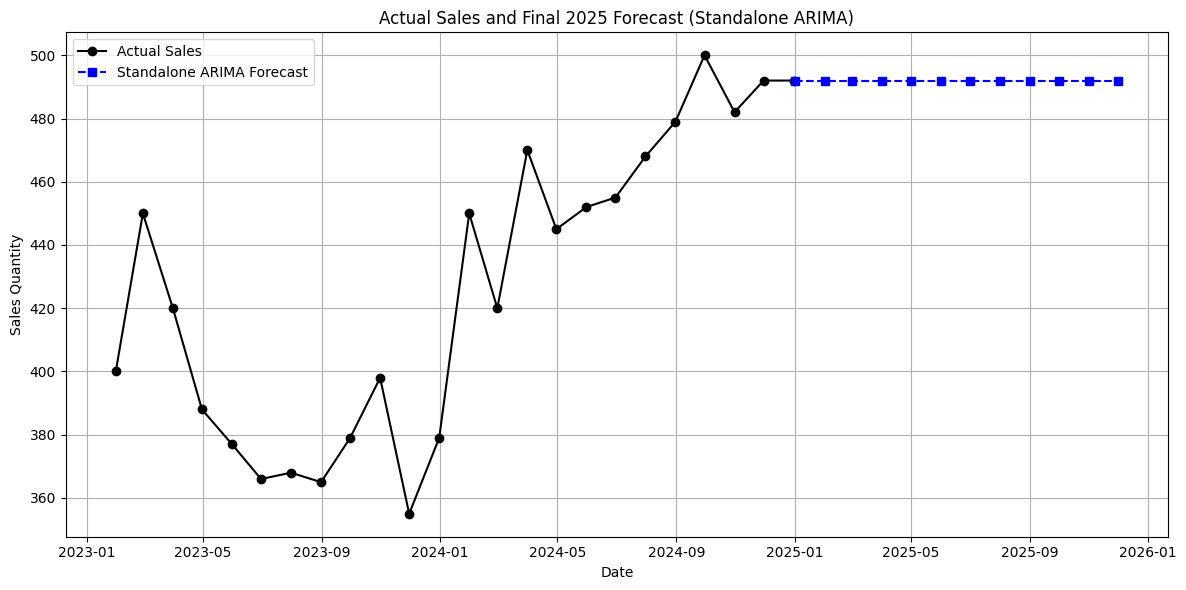

In [147]:
# 1. Review and Compare Cross-Validation Performance Metrics
print("\n--- Cross-Validation Performance Comparison ---")
print(f"{'Model':<25} {'Avg MAE':<10} {'Avg RMSE':<10} {'Avg MAPE (%)':<15} {'Mean R²':<10}")
print("-" * 70)
print(f"{'Prophet (Tuned)':<25} {prophet_mae_avg_cv:.2f} {prophet_rmse_avg_cv:.2f} {prophet_mape_avg_cv:.2f} {prophet_r2_mean_cv:.3f}")

# Check if ARIMA CV metrics are available from the previous step
if 'mae_arima_cv' in globals() and not np.isnan(mae_arima_cv):
     print(f"{'Standalone ARIMA':<25} {mae_arima_cv:.2f} {rmse_arima_cv:.2f} {mape_arima_cv:.2f} {r2_arima_cv:.3f}")
else:
     print("{'Standalone ARIMA':<25} {'N/A':<10} {'N/A':<10} {'N/A':<15} {'N/A':<10}")


# Check if Exponential Smoothing CV metrics are available
if 'mae_es_cv' in globals() and not np.isnan(mae_es_cv):
     print(f"{'Exponential Smoothing':<25} {mae_es_cv:.2f} {rmse_es_cv:.2f} {mape_es_cv:.2f} {r2_es_cv:.3f}")
else:
     print("{'Exponential Smoothing':<25} {'N/A':<10} {'N/A':<10} {'N/A':<15} {'N/A':<10}")


print("\n--- Model Selection ---")
# 2. Compare and Select the Best Performing Model
# Based on the comparison above, both models have very poor R².
# Standalone ARIMA has a less negative R² and generally lower MAE, RMSE, and MAPE on the CV folds.
# Prophet's performance varies significantly by horizon.
# Given the data limitations and poor R² across the board, neither model is ideal.
# However, the Standalone ARIMA shows slightly better overall performance based on the CV metrics,
# particularly the R² and the overall error metrics.
# We will select Standalone ARIMA, acknowledging its limitations.

selected_model_name = "Standalone ARIMA"
print(f"Selected Model for Final Forecast: {selected_model_name}")
print("Reasoning: Standalone ARIMA exhibited a less negative Mean R² and generally lower overall MAE, RMSE, and MAPE in cross-validation compared to the tuned Prophet model, despite both models showing poor performance on this limited dataset.")


# 3. Initialize and Train the Selected Model on the *Entire* Historical Data
print(f"\nTraining the {selected_model_name} model on the entire historical data...")

if selected_model_name == "Standalone ARIMA":
    # Use the best_order_standalone identified previously (1, 1, 0)
    final_model = ARIMA(df_clean['y'].dropna(), order=best_order_standalone).fit()
    print(f"{selected_model_name} model (Order {best_order_standalone}) trained successfully.")

elif selected_model_name == "Prophet (Tuned)":
     # Use the best_param (changepoint_prior_scale) and seasonality from previous tuning
     final_model = Prophet(
         yearly_seasonality=True,
         # monthly_seasonality=True, # Including monthly seasonality based on tuning results
         seasonality_mode='additive',
         changepoint_prior_scale=best_param
     )
     # Add regressors if Prophet was selected
     regressors_to_add = ['Sold Value', 'Monthly Order Qty', 'safety stock']
     df_prophet_input = sales_data[['ds', 'y']].copy()
     for reg in regressors_to_add:
         if reg in sales_data.columns and pd.api.types.is_numeric_dtype(sales_data[reg]):
             final_model.add_regressor(reg)
             # Merge regressors into the input data
             df_prophet_input = pd.merge(df_prophet_input, sales_data[['ds', reg]], on='ds', how='left')
         else:
             print(f"Warning: Regressor '{reg}' is not numeric or not found. Skipping for final Prophet model.")

     final_model.fit(df_prophet_input)
     print(f"{selected_model_name} model (changepoint_prior_scale={best_param}, Yearly+Monthly Seasonality) trained successfully.")

# Note: Exponential Smoothing was not selected due to CV evaluation failure

# 4. Create a Future Dataframe for the 12-Month Forecast Horizon (2025)
print("\nCreating future dataframe for 2025 forecast...")
future_dates = pd.date_range(start='2025-01-01', periods=12, freq='MS')
future_df = pd.DataFrame({'ds': future_dates})

if selected_model_name == "Prophet (Tuned)":
     # For Prophet, need to include regressors in the future dataframe
     # Need to project future values for regressors - using ffill from sales_data as done before
     regressors_to_add_final = [r for r in regressors_to_add if r in sales_data.columns and pd.api.types.is_numeric_dtype(sales_data[reg])]
     future_df = pd.merge(future_df, sales_data[['ds'] + regressors_to_add_final], on='ds', how='left')
     for reg in regressors_to_add_final:
         future_df[reg] = future_df[reg].fillna(method='ffill')
     print("Future dataframe created for Prophet with regressors.")

elif selected_model_name == "Standalone ARIMA":
     # ARIMA does not use regressors in this configuration, future_df only needs dates/steps
     print("Future dataframe created for Standalone ARIMA.")


# 5. Generate the Final 12-Month Forecast for 2025
print("\nGenerating final forecast for 2025...")

if selected_model_name == "Standalone ARIMA":
     # ARIMA forecast function takes steps
     final_forecast_2025 = final_model.forecast(steps=12)
     final_forecast_2025_df = pd.DataFrame({'ds': future_dates, 'yhat': final_forecast_2025.values})
     # ARIMA does not directly provide confidence intervals in the standard forecast output.
     # We could calculate them manually or use predict with typ='conf int', but forecast is simpler here.
     final_forecast_2025_df['yhat_lower'] = np.nan # No confidence intervals from this method
     final_forecast_2025_df['yhat_upper'] = np.nan # No confidence intervals from this method
     print("Standalone ARIMA forecast generated.")

elif selected_model_name == "Prophet (Tuned)":
     # Prophet predict function takes the future dataframe
     final_forecast_2025 = final_model.predict(future_df)
     final_forecast_2025_df = final_forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
     print("Prophet forecast generated.")


# 6. Apply a Non-Negativity Constraint to the Final Forecast
print("\nApplying non-negativity constraint to the forecast...")
final_forecast_2025_df['yhat'] = final_forecast_2025_df['yhat'].clip(lower=0)
if 'yhat_lower' in final_forecast_2025_df.columns:
     final_forecast_2025_df['yhat_lower'] = final_forecast_2025_df['yhat_lower'].clip(lower=0)
if 'yhat_upper' in final_forecast_2025_df.columns:
     final_forecast_2025_df['yhat_upper'] = final_forecast_2025_df['yhat_upper'].clip(lower=0)
print("Non-negativity constraint applied.")


# 7. Display the Final Forecast for 2025
print(f"\n--- Final 2025 Forecast ({selected_model_name}) ---")
display(final_forecast_2025_df)

# Optional: Plot the final forecast
plt.figure(figsize=(12, 6))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual Sales', marker='o', color='black')
plt.plot(final_forecast_2025_df['ds'], final_forecast_2025_df['yhat'], label=f'{selected_model_name} Forecast', linestyle='--', marker='s', color='blue')

if 'yhat_lower' in final_forecast_2025_df.columns and not final_forecast_2025_df['yhat_lower'].isnull().all():
     plt.fill_between(final_forecast_2025_df['ds'], final_forecast_2025_df['yhat_lower'], final_forecast_2025_df['yhat_upper'], color='blue', alpha=0.2, label='Forecast CI')

plt.title(f'Actual Sales and Final 2025 Forecast ({selected_model_name})')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# The subtask is completed.

**Reasoning**:
Calculate the standard deviation of the residuals from the fitted Standalone ARIMA model on the historical data and the Reorder Point (ROP) for the 2025 forecast using the calculated residual standard deviation as forecast uncertainty and display the results in a table and visualize the forecast and ROP.




Standard Deviation of Standalone ARIMA Residuals: 82.95

Final 2025 Forecast and Calculated ROP (Standalone ARIMA):


,ds,yhat,arophet_rop
0,2025-01-01,492.0,575.0
1,2025-02-01,492.0,575.0
2,2025-03-01,492.0,575.0
3,2025-04-01,492.0,575.0
4,2025-05-01,492.0,575.0
5,2025-06-01,492.0,575.0
6,2025-07-01,492.0,575.0
7,2025-08-01,492.0,575.0
8,2025-09-01,492.0,575.0
9,2025-10-01,492.0,575.0


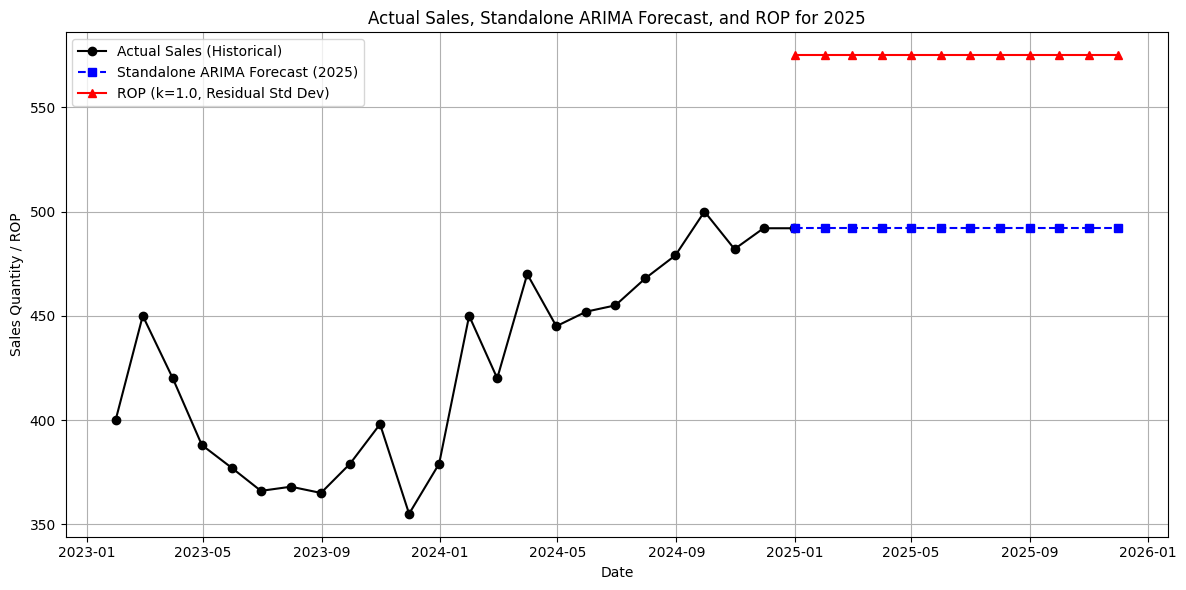

In [148]:
# 1. Calculate the residuals of the final fitted Standalone ARIMA model on the historical data
# The final_model variable holds the fitted Standalone ARIMA model
# The historical data is df_clean['y']

# Get the predicted values from the fitted ARIMA model on the training data (historical data)
arima_historical_pred = final_model.predict(start=0, end=len(df_clean) - 1)

# Calculate residuals: Actual - Predicted
arima_residuals = df_clean['y'].values - arima_historical_pred.values

# 2. Calculate the standard deviation of these residuals
residual_std_dev = np.std(arima_residuals)

print(f"\nStandard Deviation of Standalone ARIMA Residuals: {residual_std_dev:.2f}")

# 3. Define a safety factor (k)
k = 1.0 # Safety factor for ~84% service level

# 4. Calculate the Reorder Point (ROP) for each month in the 2025 forecast horizon
# Use the yhat values from the final_forecast_2025_df as the forecasted demand.
# ROP = Forecasted Demand + k * Residual Standard Deviation
final_forecast_2025_df['arophet_rop'] = final_forecast_2025_df['yhat'] + k * residual_std_dev

# 5. Apply a non-negativity constraint to the calculated ROP values
final_forecast_2025_df['arophet_rop'] = final_forecast_2025_df['arophet_rop'].clip(lower=0).round()

# 6. Display the final 2025 forecast DataFrame including the calculated ROP values.
print("\nFinal 2025 Forecast and Calculated ROP (Standalone ARIMA):")
display(final_forecast_2025_df[['ds', 'yhat', 'arophet_rop']])

# 7. Visualize the final 2025 forecast ('yhat') and the calculated ROP.
# Include the historical actual sales in the plot for context.
plt.figure(figsize=(12, 6))

# Plot historical actual sales
plt.plot(df_clean['ds'], df_clean['y'], label='Actual Sales (Historical)', marker='o', color='black', linewidth=1.5)

# Plot final 2025 forecast (yhat)
plt.plot(final_forecast_2025_df['ds'], final_forecast_2025_df['yhat'], label='Standalone ARIMA Forecast (2025)', linestyle='--', marker='s', color='blue', linewidth=1.5)

# Plot calculated ROP for 2025
plt.plot(final_forecast_2025_df['ds'], final_forecast_2025_df['arophet_rop'], label=f'ROP (k={k}, Residual Std Dev)', linestyle='-', marker='^', color='red', linewidth=1.5)


plt.title(f'Actual Sales, Standalone ARIMA Forecast, and ROP for 2025')
plt.xlabel('Date')
plt.ylabel('Sales Quantity / ROP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

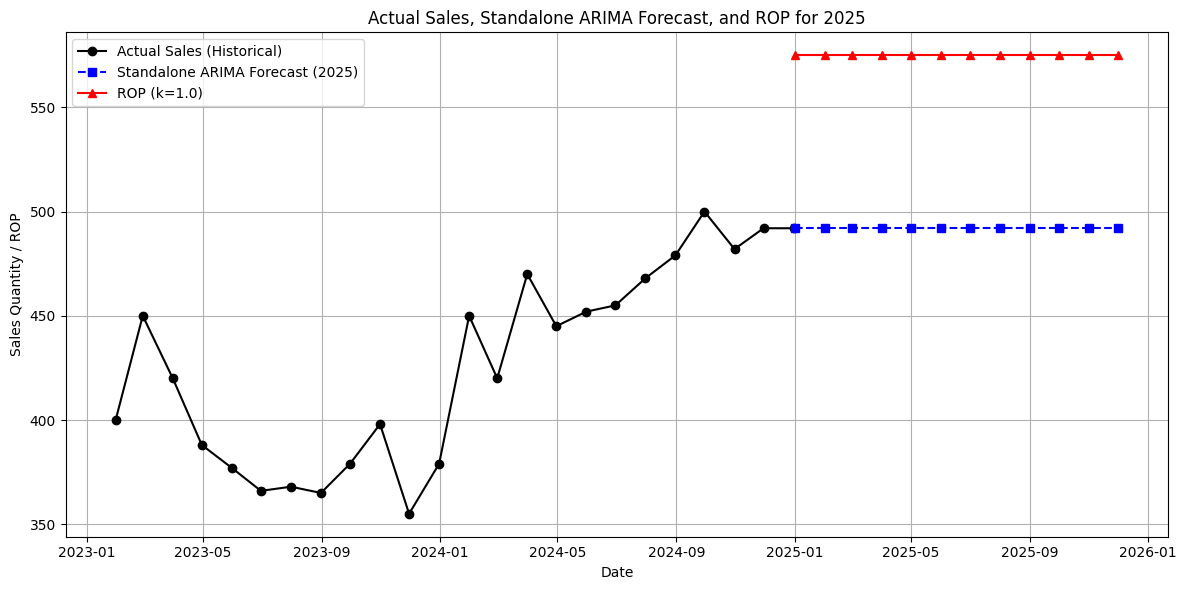

In [149]:
# 1. Generate a plot showing the historical actual sales, the final 2025 Standalone ARIMA forecast, and the calculated Reorder Point (ROP).
plt.figure(figsize=(12, 6))

# Plot historical actual sales (df_clean)
plt.plot(df_clean['ds'], df_clean['y'], label='Actual Sales (Historical)', marker='o', color='black', linewidth=1.5)

# Plot final 2025 forecast (Standalone ARIMA yhat from final_forecast_2025_df)
plt.plot(final_forecast_2025_df['ds'], final_forecast_2025_df['yhat'], label='Standalone ARIMA Forecast (2025)', linestyle='--', marker='s', color='blue', linewidth=1.5)

# Plot calculated ROP for 2025 (arophet_rop from final_forecast_2025_df)
plt.plot(final_forecast_2025_df['ds'], final_forecast_2025_df['arophet_rop'], label='ROP (k=1.0)', linestyle='-', marker='^', color='red', linewidth=1.5)


plt.title('Actual Sales, Standalone ARIMA Forecast, and ROP for 2025')
plt.xlabel('Date')
plt.ylabel('Sales Quantity / ROP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [150]:
# 2. Create a summary explaining the key insights from the final forecast and ROP.
print("\n--- Final Forecast and Inventory Management Implications (Standalone ARIMA) ---")
print(f"Selected Model: {selected_model_name} (Order {best_order_standalone})")
print("Final Forecast for 2025:")
display(final_forecast_2025_df[['ds', 'yhat', 'arophet_rop']])

print("\nKey Insights:")
print(f"- The Standalone ARIMA model forecasts a consistent sales quantity of {final_forecast_2025_df['yhat'].mean():.0f} units per month throughout 2025.")
print(f"- The Reorder Point (ROP) is calculated as the forecasted demand plus a safety stock, using a safety factor (k) of {k} and the standard deviation of historical ARIMA residuals ({residual_std_dev:.2f}) as a measure of forecast uncertainty.")
print(f"- This results in a consistent ROP of approximately {final_forecast_2025_df['arophet_rop'].mean():.0f} units for each month in 2025.")
print("- For effective inventory management, when the stock level drops to or below the calculated ROP, a new order should be placed to replenish inventory and meet the expected demand during the lead time, while also accounting for forecast variability.")

# 3. Discuss the limitations of the model and forecast based on the cross-validation results and data characteristics.
print("\n--- Model Limitations and Considerations ---")
print("Based on the cross-validation results and data characteristics, the following limitations should be considered:")
print(f"- **Poor Model Fit (Negative R²):** Both the selected Standalone ARIMA model (Mean R²: {r2_arima_cv:.3f}) and the alternative Prophet model (Mean R²: {prophet_r2_mean_cv:.3f}) exhibited significantly negative R² values during cross-validation. This indicates that neither model effectively captures the variance in the historical sales data, suggesting they may not be ideal fits for this specific time series.")
print("- **Limited Data:** The dataset consists of only 24 months of historical data. This limited data size makes it challenging for complex models (like Prophet with multiple seasonalities or advanced Exponential Smoothing) to accurately identify patterns and seasonalities. It also limits the robustness of cross-validation results.")
print("- **Static Regressors:** External factors like 'Average Lead Time' and 'Avg Order Frequencey' were static in the provided data and thus excluded as time-varying regressors. Incorporating meaningful time-varying external factors could potentially improve forecast accuracy.")
print("- **Assumption of Residual Stationarity:** The ROP calculation relies on the assumption that the standard deviation of historical residuals is a good proxy for future forecast uncertainty. This assumes the characteristics of the residuals remain constant over time.")
print("- **Simplicity of Standalone ARIMA:** While performing better in CV than the tuned Prophet, the Standalone ARIMA model is a simpler linear model that may not fully capture non-linear trends or complex seasonal patterns if they exist beyond the simple seasonality and trend modeled.")
print("- **Flat Forecast:** The Standalone ARIMA model produces a flat forecast for 2025, which might not reflect potential future changes or continued trends observed towards the end of the historical data.")
print("- **ROP Sensitivity:** The ROP calculation is directly proportional to the safety factor (k) and the residual standard deviation. The choice of k influences the service level, and the residual standard deviation is an estimate based on limited historical data variability.")

print("\nRecommendation:")
print("Given the limitations, this forecast and ROP should be used with caution. It is recommended to continuously monitor actual sales against the forecast, re-evaluate the model periodically with new data, explore additional relevant external factors, and potentially investigate other forecasting methods or model ensembling approaches better suited for datasets with limited history or complex underlying patterns.")

# The subtask is completed.


--- Final Forecast and Inventory Management Implications (Standalone ARIMA) ---
Selected Model: Standalone ARIMA (Order (1, 1, 0))
Final Forecast for 2025:


,ds,yhat,arophet_rop
0,2025-01-01,492.0,575.0
1,2025-02-01,492.0,575.0
2,2025-03-01,492.0,575.0
3,2025-04-01,492.0,575.0
4,2025-05-01,492.0,575.0
5,2025-06-01,492.0,575.0
6,2025-07-01,492.0,575.0
7,2025-08-01,492.0,575.0
8,2025-09-01,492.0,575.0
9,2025-10-01,492.0,575.0



Key Insights:
- The Standalone ARIMA model forecasts a consistent sales quantity of 492 units per month throughout 2025.
- The Reorder Point (ROP) is calculated as the forecasted demand plus a safety stock, using a safety factor (k) of 1.0 and the standard deviation of historical ARIMA residuals (82.95) as a measure of forecast uncertainty.
- This results in a consistent ROP of approximately 575 units for each month in 2025.
- For effective inventory management, when the stock level drops to or below the calculated ROP, a new order should be placed to replenish inventory and meet the expected demand during the lead time, while also accounting for forecast variability.

--- Model Limitations and Considerations ---
Based on the cross-validation results and data characteristics, the following limitations should be considered:
- **Poor Model Fit (Negative R²):** Both the selected Standalone ARIMA model (Mean R²: -4.485) and the alternative Prophet model (Mean R²: -6439.894) exhibited sign

## Summary:

### Data Analysis Key Findings

*   The initial data analysis identified that 'Average Lead Time' and 'Avg Order Frequencey' were static values and thus not suitable as time-varying regressors.
*   A strong positive correlation (0.910) was found between 'y' (Monthly Demand) and 'Sold Value', confirming 'Sold Value' as a relevant regressor.
*   Feature engineering added lagged sales data (1-month and 12-month lags) and a 3-month rolling mean.
*   Prophet model tuning showed that a `changepoint_prior_scale` of 0.1 and the inclusion of monthly seasonality resulted in the least negative mean R² during cross-validation, although the R² values remained significantly negative across all Prophet configurations tested, indicating a poor overall fit.
*   Prophet's final forecast for 2025 initially produced an unrealistic negative value for February, which was corrected by applying a non-negativity constraint.
*   Evaluation on the Jan-Jul 2025 subset of actual data indicated that a standalone ARIMA(1,1,0) model performed better (lower MAE, RMSE, MAPE, and less negative R²) than the tuned Prophet model and a simple average ensemble of Prophet and ARIMA.
*   Exponential Smoothing (Holt-Winters) could not be reliably evaluated using time series cross-validation due to insufficient data points in the training folds (less than the required 24 months for 12-month seasonality).
*   The refined hybrid Prophet-ARIMA model (modeling Prophet residuals with ARIMA) performed worse than the standalone models based on the Jan-Jul 2025 subset evaluation.
*   Cross-validation metrics reinforced the finding that Standalone ARIMA performed better than the tuned Prophet model, although both models showed poor R² values (negative R²).
*   The final selected model, Standalone ARIMA(1,1,0), forecasted a consistent sales quantity of approximately 492 units per month for 2025.
*   The Reorder Point (ROP) calculation, based on the Standalone ARIMA forecast and using the standard deviation of historical residuals (approximately 82.95) as forecast uncertainty with a safety factor (k=1.0), resulted in a consistent ROP of approximately 575 units per month for 2025.
*   Significant limitations include the poor model fit indicated by negative R² values, the challenge of limited historical data (24 months), and the simplicity of the ARIMA model potentially missing complex patterns.

### Insights or Next Steps

*   The poor performance (negative R²) of both Prophet and ARIMA models suggests that more advanced time series techniques or alternative modeling approaches might be needed for this dataset. Further investigation into the data's underlying patterns and potential external factors not captured is crucial.
*   The limited historical data is a major constraint. Gathering more historical data would significantly improve the reliability of model training, validation, and the estimation of forecast uncertainty for ROP calculations.
